# ARR Analysis

## Goal

ARR prediction, where ARR=RoomIncome_Main/room_nights

## Roadmap

1. sss
1. xxx
1. aaa

1. Load datasets + quick analysis
1. Features Engineering (+Cleaning)
1. Exploratory Data Analysis (EDA)
    - High level statistics
    - Features Histograms
    - Data Encoding (categorigal+numeric)
    - Correlation Matrix
1. Basic Modelling
    - Linear Regression
    - Ridge (L2)
    - Lasso (L1)
    - Elastic-Net (L1+L2)
    - Support Vector Regression (SVR)
1. Trees
    - Decision Trees
    - Random Forest (ensemble)
    - XGBoost (boosted)
1. Neural Networks
    - Multi-layer Perceptron
    - LSTM RNN (Tensorflow)
    - LSTM AutoEncoder (Tensorflow)
1. Statistical Forcasting
    - SARIMAX
    - FBProphet
 
<br><br>
<div><img src="https://miro.medium.com/max/1400/1*OmxKKDqcVm_UCOYT9i5TJw.png" width=750"/></div>

<hr>

# Initialization

Import required libraries

In [16]:
import glob
import json
import shap
import xlrd
import pylab
import codecs
import joblib
import datetime
import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
import statsmodels.api as sm
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from os import path, environ
from fbprophet import Prophet
from sklearn.svm import LinearSVR
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.inspection import plot_partial_dependence, permutation_importance
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score, GridSearchCV
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
sns.set(color_codes=True)

pylab.rcParams['figure.figsize'] = (60.0, 20.0)
pylab.rcParams['font.size'] = 14
pylab.rcParams['figure.max_open_warning'] = 0

sns.set(); sns.reset_defaults

%matplotlib inline

print("pandas version: %s" % str(pd.__version__))
print("tensorflow version: %s" % str(tf.__version__))
print("xgboost version: %s" % str(xgb.__version__))

pandas version: 1.1.0
tensorflow version: 2.3.0
xgboost version: 1.0.0


## User Parameters:

In [2]:
dataset_path = "../Data/Ramblas/Ramblas.txt"
events_path = "../Data/Ramblas/eventsBarcelona.xlsx"
avail_path = "../Data/Ramblas/RamblaAvail/*.txt"
additional_path = "../Data/Ramblas/AddistionalSpainData.xlsx"
competition_demand_path = "../Data/Ramblas/Competition/HotelRankDemand.txt"
competition_rates_path = "../Data/Ramblas/Competition/HotelRates.txt"
plangrp_path = None

save_path = 'saved_data/'
scaling_mode = "standard"
hyper_params_en = False
overwrite_saved_data = False

index_var = 'res_date'
dependent_var ='ARR'

m_lead_days_max = 300
room_nights_min = 0
room_nights_max = 7
RoomIncome_Main_min = 0
RoomIncome_Main_max = 4000
dependent_var_max = 400
cv_ratio = 0.2
singles_only = False
fulfilled_only = False

models = ['linear_regressor',       # 0
          'ridge_regressor',        # 1
          'lasso_regressor',        # 2
          'elasticnet_regressor',   # 3
          'supportvect_regressor',  # 4 
          'decisiontree_regressor', # 5
          'randomforest_regressor', # 6
          'xgboost_regressor',      # 7
          'mlp_regressor',          # 8
          'lstm_rnn',               # 9
          'lstm_autoencoder',       # 10
          'sarima',                 # 11
          'fbprophet']              # 12

Specific Hotel selection

In [3]:
if not 'hotel_sel' in locals():
    hotel_sel = 468.0 

## Reservations dataset

In [26]:
reservations_data = pd.read_csv(dataset_path, sep='\t', lineterminator='\r')
reservations_data[index_var]=pd.to_datetime(reservations_data[index_var].astype(str), format='%Y-%m-%d')
reservations_data = reservations_data[reservations_data[index_var] < '2020-03-01']

display(reservations_data.head())

hotels = reservations_data['hotel'].unique()
hotels = np.sort(hotels[~np.isnan(hotels)])
print('Hotels:\n%s\n' % str(hotels))
print('Selected: %s\n' % str(hotel_sel))

res_date  hotel  master  res  wing  group_member nationality  \
0 2018-12-15    468   42595    1   1.0             0         fra   
1 2019-01-18    468   42647    1   1.0             0         gbr   
2 2019-01-19    468   42647    1   1.0             0         gbr   
3 2019-01-17    468   42647    1   1.0             0         gbr   
4 2019-02-10    468   42851    1   1.0             0         otr   

   m_length_of_stay  bed_nights  room_nights  ...  Cxl_Reason_code  \
0                 1           2          1.0  ...              NaN   
1                 3           2          1.0  ...              NaN   
2                 3           2          1.0  ...              NaN   
3                 3           2          1.0  ...              NaN   
4                20           1          1.0  ...              NaN   

  CXL_LeadDays adults  juniors  children  babies  club_code StatisticSource  \
0          NaN    NaN      NaN       NaN     NaN        NaN             NaN   
1          NaN    NaN      NaN       NaN     NaN        NaN             NaN   
2          NaN    NaN      NaN       NaN     NaN        NaN             NaN   
3          NaN    NaN      NaN       NaN     NaN        NaN             NaN   
4         38.0    NaN      NaN       NaN     NaN        NaN             NaN   

   Commission_Main  Commission_Second  
0              NaN                NaN  
1              NaN                NaN  
2              NaN                NaN  
3              NaN                NaN  
4              NaN                NaN  

[5 rows x 41 columns]

Hotels:
[468]

Selected: 468.0



## Special Events

events_df (123, 9)


FairId           FairName   FromDate     ToDate Scope Hotel/ Region Code  \
0      26  Barcelona Meeting 2015-10-21 2015-10-24  City          Barcelona   
1      37            Gastech 2018-09-17 2018-09-20  City          Barcelona   
2      62   CPHI - Barcelona 2016-10-04 2016-10-06  City          Barcelona   
3     133            Estudia 2016-03-09 2016-03-13  City          Barcelona   
4     133            Estudia 2017-03-22 2017-03-26  City          Barcelona   

  Hotel/ Region Name Fair Category  HotelId  
0          Barcelona             A        0  
1          Barcelona             B        0  
2          Barcelona             A        0  
3          Barcelona             C        0  
4          Barcelona             C        0

Text(0.5, 1.0, 'Special Events - FairID Histogram')

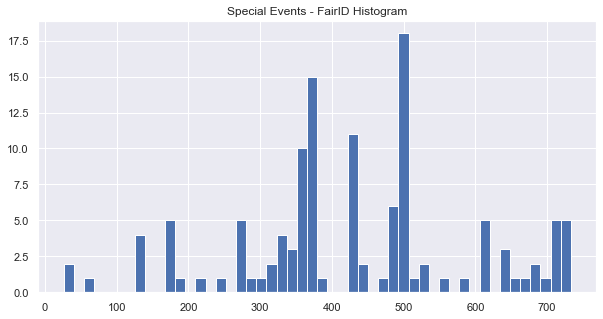

In [36]:
events_df = pd.read_excel(events_path)

print('events_df', events_df.shape)
display(events_df.head())

fig, ax = plt.subplots(1, 1, figsize=(10,5))
events_df["FairId"].hist(bins=50, ax=ax)    
ax.set_title('Special Events - FairID Histogram')

## Additional Information

Spain and Barcelona: RN, ADR, Rev, OCC

additional_df (1186, 8)


RN_Barcelona  ADR_Barcelona  Rev_Barcelona  OCC_Barcelona  \
Res_Date                                                                
2017-01-01         131.0          125.4        16424.0         0.7043   
2017-01-02          92.0           93.1         8565.0         0.4946   
2017-01-03         114.0           80.6         9189.0         0.6129   
2017-01-04         112.0           80.3         8997.0         0.6022   
2017-01-05         121.0           75.3         9110.0         0.6505   

            RN_Spain  ADR_Spain  Rev_Spain  OCC_Spain  
Res_Date                                               
2017-01-01       355       82.5    29273.0     0.5976  
2017-01-02       305       63.1    19256.0     0.5135  
2017-01-03       365       58.4    21318.0     0.6145  
2017-01-04       360       57.4    20650.0     0.6061  
2017-01-05       310       57.7    17888.0     0.5219

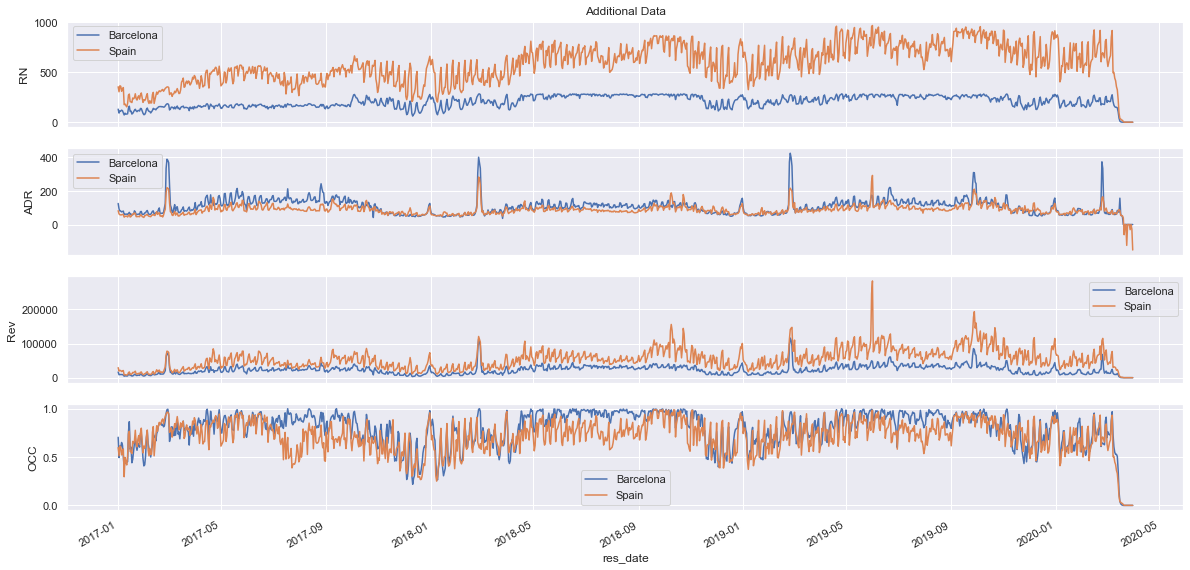

In [28]:
sheet_names = list(pd.read_excel(additional_path, None).keys())

df1 = pd.read_excel(additional_path, sheet_name=sheet_names[0])
df2 = pd.read_excel(additional_path, sheet_name=sheet_names[1])

additional_df = df1.merge(df2,
                          left_on='Res_Date', 
                          right_on='Res_Date',
                          suffixes=('_' + sheet_names[0], '_' + sheet_names[1]))
                         
additional_df = additional_df.set_index('Res_Date')
additional_df = additional_df.replace('(null)',np.nan).fillna(0)

print('additional_df', additional_df.shape)
display(additional_df.head())

x = additional_df.index.unique()
fig, ax = plt.subplots(4,1,figsize=(20,10), sharex=True)
for k, txt in enumerate(['RN', 'ADR', 'Rev', 'OCC']):
    ax[k].plot(x, additional_df[txt+'_Barcelona'], additional_df[txt+'_Spain'])
    ax[k].set_ylabel(txt)
    ax[k].legend(['Barcelona', 'Spain'])
ax[0].set_title('Additional Data')
ax[3].set_xlabel(index_var)
ax[3].xaxis_date()
fig.autofmt_xdate()
plt.show()

## Availability

availability_df (1461, 4)


date_taken  AvailRooms  hotel_rooms  capacity
178784 2016-01-02       117.0        117.0       1.0
178785 2016-01-03       117.0        117.0       1.0
171640 2016-01-04       117.0        117.0       1.0
171641 2016-01-05       117.0        117.0       1.0
169657 2016-01-06       117.0        117.0       1.0

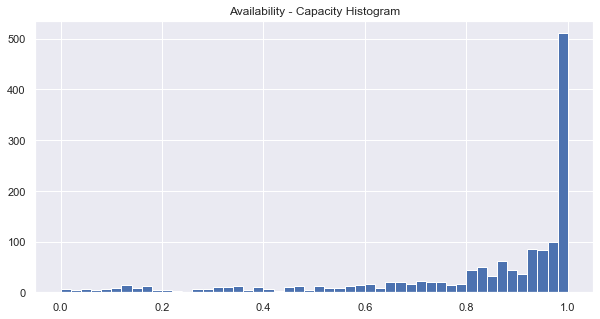

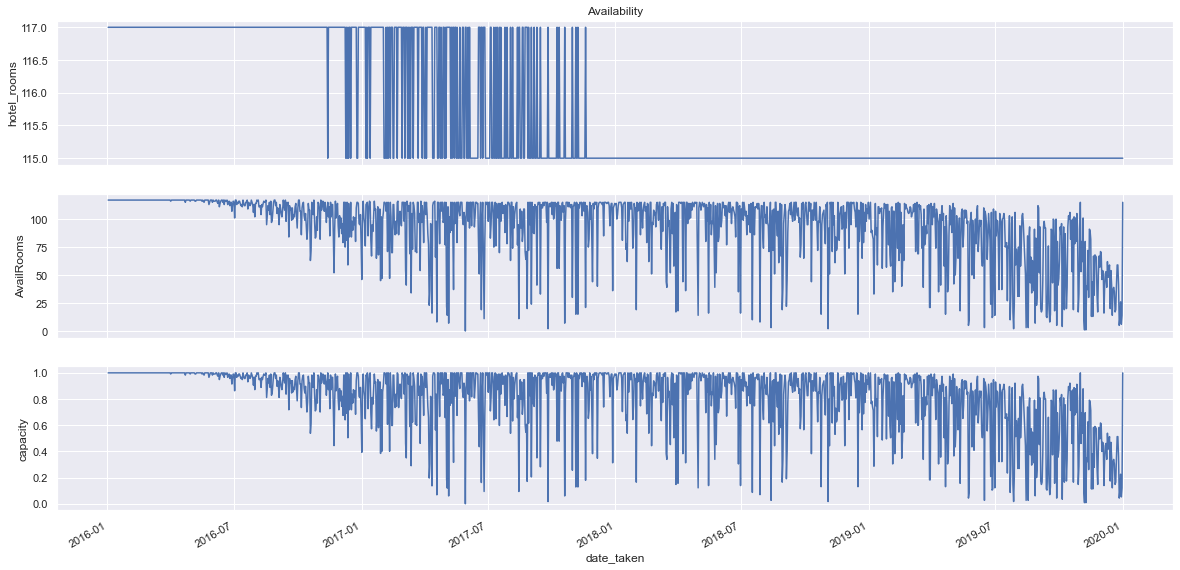

In [37]:
if avail_path:
    
    all_files = glob.glob(avail_path)

    li = []
    for filename in all_files:
        df = pd.read_csv(filename, index_col=None, header=0, low_memory=False, sep=',', encoding='utf-16')
        li.append(df)

    availability_df = pd.concat(li, axis=0, ignore_index=True)

    availability_df['date_taken'] = availability_df['date_taken'].astype('datetime64')

    availability_df['capacity'] = availability_df['AvailRooms'] / availability_df['hotel_rooms']
    availability_df['capacity'] = availability_df['capacity'].clip(lower=0)

    availability_df = availability_df[availability_df['hotel'] == hotel_sel].drop('hotel', axis=1)
    availability_df = availability_df.drop('res_date', axis=1).sort_values('date_taken')
    availability_df = availability_df.drop_duplicates(subset='date_taken', keep='last')

    print('availability_df', availability_df.shape)
    display(availability_df.head())
    
    fig, ax = plt.subplots(1, 1, figsize=(10,5))
    availability_df['capacity'].hist(bins=50, ax=ax)    
    ax.set_title('Availability - Capacity Histogram')
        
    x = availability_df.date_taken.unique()
    fig, ax = plt.subplots(3,1,figsize=(20,10), sharex=True)
    ax[0].plot(x, availability_df['hotel_rooms'])
    ax[1].plot(x, availability_df['AvailRooms'])
    ax[2].plot(x, availability_df['capacity'])
    ax[0].set_ylabel('hotel_rooms')
    ax[1].set_ylabel('AvailRooms')
    ax[2].set_ylabel('capacity')
    ax[0].set_title('Availability')
    ax[2].set_xlabel('date_taken')
    fig.autofmt_xdate()
    ax[2].xaxis_date()
    plt.show()    

Load Plan Grouping

In [12]:
if plangrp_path:

    plan_grouping_df = pd.read_excel(plangrp_path)
    plan_grouping_df.columns = [*plan_grouping_df.columns[:-1], 'plan_code']

    print('plan_grouping_df', plan_grouping_df.shape)
    display(plan_grouping_df.head())

Load Competition data

competition_demand_df (1830, 6)


Date_Taken   Res_Date  Demand_Barcelona  Rank_Barcelona  Demand_Madrid  \
0    2019-07-02 2019-07-02          0.731612        0.202186       0.703464   
1    2019-07-02 2019-07-03          0.814998        0.063063       0.689329   
2    2019-07-02 2019-07-04          0.811449        0.173770       0.657782   
3    2019-07-02 2019-07-05          0.806277        0.271511       0.665483   
4    2019-07-02 2019-07-06          0.774100        0.260317       0.788429   
...         ...        ...               ...             ...            ...   
1825 2019-08-30 2020-08-25          0.000000        0.000000       0.000000   
1826 2019-08-30 2020-08-26          0.000000        0.000000       0.000000   
1827 2019-08-30 2020-08-27          0.000000        0.000000       0.000000   
1828 2019-08-30 2020-08-28          0.000000        0.000000       0.000000   
1829 2019-08-30 2020-08-29          0.000000        0.000000       0.000000   

      Rank_Madrid  
0        0.011665  
1        0.038000  
2        0.124000  
3        0.080026  
4        0.030733  
...           ...  
1825     0.000000  
1826     0.000000  
1827     0.000000  
1828     0.000000  
1829     0.000000  

[1830 rows x 6 columns]

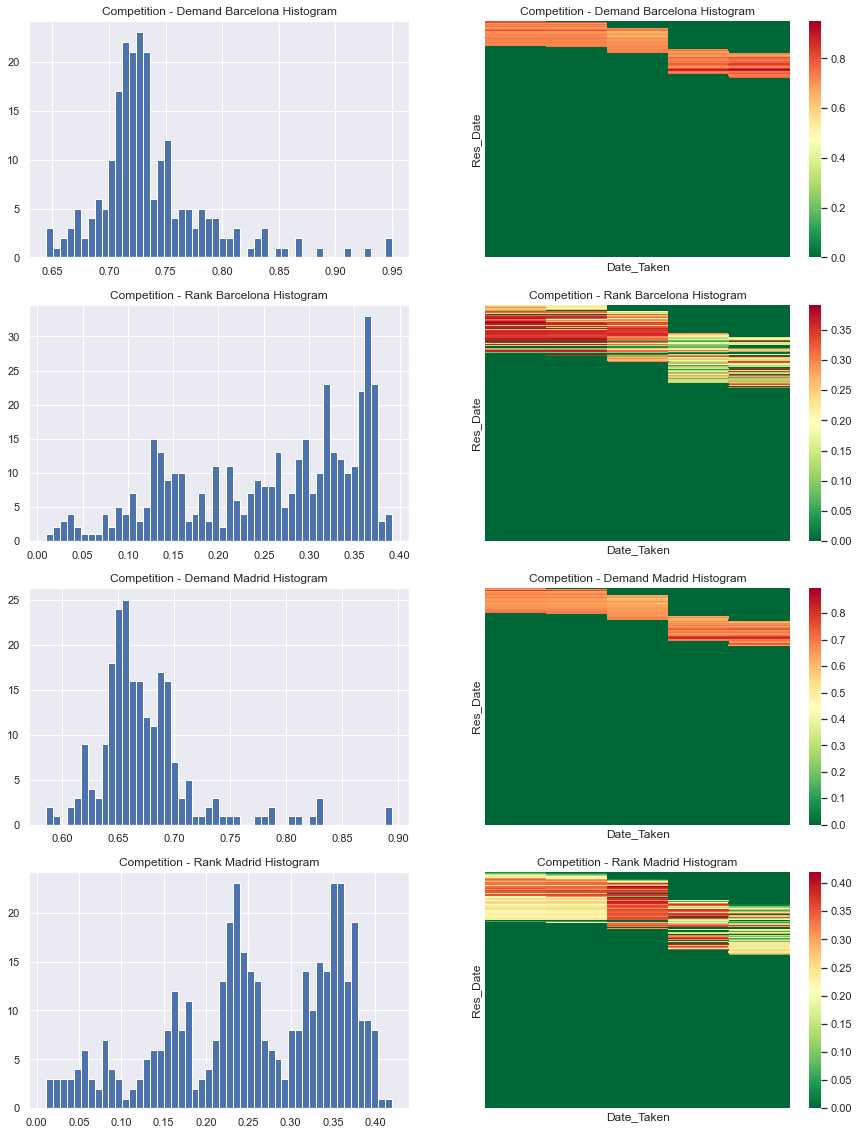

In [105]:
if competition_demand_path:    

    competition_demand_df = pd.read_csv(competition_demand_path, sep='\t', encoding='latin1')
    
    competition_demand_df['Res_Date'] = competition_demand_df['Res_Date'].astype('datetime64[ns]')
    competition_demand_df['Date_Taken'] = competition_demand_df['Date_Taken'].astype('datetime64[ns]')

    tmp_series = competition_demand_df['Rank'].str.extract(r'(.*) of (.*)').fillna(0).astype(int)    
    competition_demand_df['Rank'] = (tmp_series[0]/tmp_series[1]).fillna(0)
    
    competition_demand_df = competition_demand_df.fillna(0)
    competition_demand_df['is_madrid'] = competition_demand_df['File_name'].str.contains('MADRID').astype(int)
    competition_demand_df = competition_demand_df.drop(['Hotel_Name', 'File_name', 'hotel'], axis=1)
    competition_demand_df = competition_demand_df[competition_demand_df['Res_Date'] != 0]
    
    df1 = competition_demand_df[competition_demand_df['is_madrid'] == 0].drop('is_madrid',  axis=1)
    df2 = competition_demand_df[competition_demand_df['is_madrid'] == 1].drop('is_madrid',  axis=1)
    
    competition_demand_df = df1.merge(df2,
                                      left_on=['Res_Date', 'Date_Taken'],
                                      right_on=['Res_Date', 'Date_Taken'],
                                      suffixes=('_Barcelona', '_Madrid'))
        
    competition_demand_df = competition_demand_df.groupby(['Date_Taken', 'Res_Date']).mean()
    competition_demand_df = competition_demand_df.reset_index().sort_values(['Date_Taken', 'Res_Date'])
    
    print('competition_demand_df', competition_demand_df.shape)
    display(competition_demand_df)
    
    # Plot:
    fig, ax = plt.subplots(4, 2, figsize=(15,20))
    
    for k,feature in enumerate(competition_demand_df.columns[-4:].to_list()):
        
        feature_arr = competition_demand_df[feature].to_numpy()
        feature_arr = feature_arr[feature_arr.nonzero()]

        pd.Series(feature_arr).hist(bins=50, ax=ax[k][0])
        
        df = competition_demand_df.pivot(index='Res_Date',
                                         columns='Date_Taken',
                                         values=feature).fillna(0)        

        sns.heatmap(df, ax=ax[k][1], cmap='RdYlGn_r', yticklabels=False, xticklabels=False)

        ax[k][0].set_title('Competition - ' + feature.replace('_', ' ') + ' Histogram')
        ax[k][1].set_title('Competition - ' + feature.replace('_', ' ') + ' Histogram')

    #fig.autofmt_xdate()
    
    plt.show()    

competition_rates_df (1830, 4)


Date_Taken   Res_Date  Hotel_Rate_Barcelona  Hotel_Rate_Madrid
0    2019-07-02 2019-07-02            107.060606         102.954545
1    2019-07-02 2019-07-03            113.030303         101.227273
2    2019-07-02 2019-07-04            137.878788         111.000000
3    2019-07-02 2019-07-05            144.848485          98.772727
4    2019-07-02 2019-07-06            147.000000          89.136364
...         ...        ...                   ...                ...
1825 2019-08-30 2020-08-25             71.606061          87.863636
1826 2019-08-30 2020-08-26             73.545455          87.863636
1827 2019-08-30 2020-08-27             83.575758          87.454545
1828 2019-08-30 2020-08-28             73.575758          88.227273
1829 2019-08-30 2020-08-29             23.727273          47.090909

[1830 rows x 4 columns]

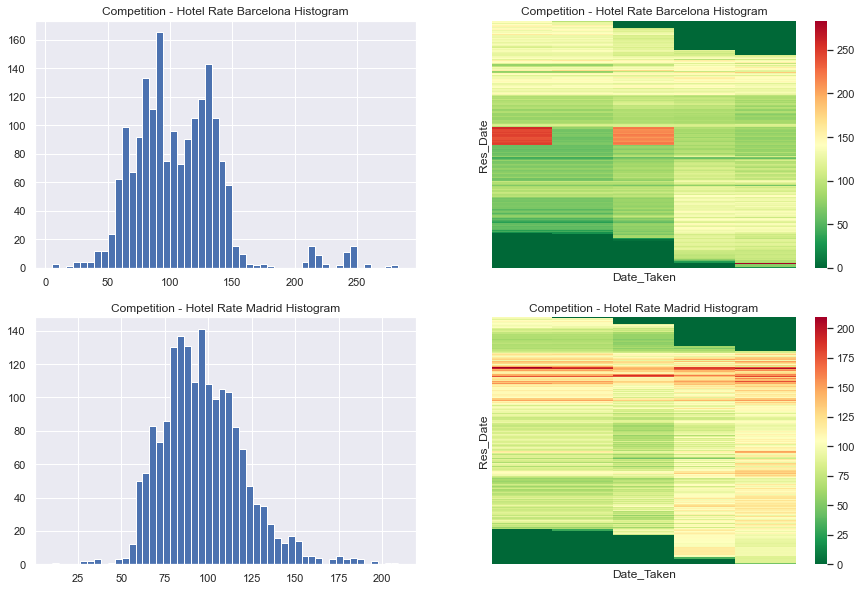

In [106]:
if competition_rates_path:

    competition_rates_df = pd.read_csv(competition_rates_path, sep='\t', encoding='latin1')
    
    competition_rates_df['Res_Date'] = competition_rates_df['Res_Date'].astype('datetime64[ns]')
    competition_rates_df['Date_Taken'] = competition_rates_df['Date_Taken'].astype('datetime64[ns]')

    competition_rates_df['Hotel_Rate'] = pd.to_numeric(competition_rates_df['Hotel_Rate'], errors='coerce')
    competition_rates_df['Hotel_Rate'] = competition_rates_df['Hotel_Rate'].replace(np.NaN, 0)
    
    competition_rates_df = competition_rates_df.fillna(0)
    competition_rates_df['is_madrid'] = competition_rates_df['File_Name'].str.contains('MADRID').astype(int)
    competition_rates_df = competition_rates_df.drop(['Hotel_Name', 'File_Name'], axis=1)
    competition_rates_df = competition_rates_df[competition_rates_df['Res_Date'] != 0]
    
    df1 = competition_rates_df[competition_rates_df['is_madrid'] == 0].drop('is_madrid',  axis=1)
    df2 = competition_rates_df[competition_rates_df['is_madrid'] == 1].drop('is_madrid',  axis=1)
    
    competition_rates_df = df1.merge(df2,
                                     left_on=['Res_Date', 'Date_Taken'],
                                     right_on=['Res_Date', 'Date_Taken'],
                                     suffixes=('_Barcelona', '_Madrid'))

    competition_rates_df = competition_rates_df.groupby(['Date_Taken', 'Res_Date']).mean()
    competition_rates_df = competition_rates_df.reset_index().sort_values(['Date_Taken', 'Res_Date'])

    print('competition_rates_df', competition_rates_df.shape)
    display(competition_rates_df)
    
    # Plot:
    fig, ax = plt.subplots(2, 2, figsize=(15,10))
    
    for k,feature in enumerate(competition_rates_df.columns[-2:].to_list()):
        
        feature_arr = competition_rates_df[feature].to_numpy()
        feature_arr = feature_arr[feature_arr.nonzero()]

        pd.Series(feature_arr).hist(bins=50, ax=ax[k][0])        
        
        df = competition_rates_df.pivot(index='Res_Date',
                                        columns='Date_Taken',
                                        values=feature).fillna(0)        

        sns.heatmap(df, ax=ax[k][1], cmap='RdYlGn_r', yticklabels=False, xticklabels=False)

        ax[k][0].set_title('Competition - ' + feature.replace('_', ' ') + ' Histogram')
        ax[k][1].set_title('Competition - ' + feature.replace('_', ' ') + ' Histogram')

    #fig.autofmt_xdate()
    
    plt.show()

<hr>

# Features Engineering (+Cleaning)

## Reservations Dataset

Focus on relevant reservation dataset + Cleaning

In [210]:
reservations_data2 = reservations_data.copy()

# Focus on a specific hotel:
reservations_data2 = reservations_data2[reservations_data2['hotel'] == hotel_sel]

reservations_data2['date_taken'] = pd.to_datetime(reservations_data2['Date_taken'], errors='coerce')
reservations_data2['date_taken'] = reservations_data2['date_taken'].dt.date.astype(str)

# Clean (filter):
reservations_data2 = reservations_data2[(reservations_data2['m_lead_days']<m_lead_days_max) &
                                        (reservations_data2['room_nights']>room_nights_min) & 
                                        (reservations_data2['room_nights']<room_nights_max) &
                                        (reservations_data2['RoomIncome_Main']>RoomIncome_Main_min) &
                                        (reservations_data2['RoomIncome_Main']<RoomIncome_Main_max)]
reservations_data2['date_taken'] = reservations_data2['date_taken'].astype('datetime64[ns]')

# Keep only Singles reservations:
if singles_only:
    singles_ids = [1, 4, 6, 11, 15, 21, 30, 31, 34]
    reservations_data2 = reservations_data2[reservations_data2['market_segment_bi_id'].isin(singles_ids)]

# Keep only fulfilled reservations:
if fulfilled_only:
    fulfilled_ids = ['arriv', 'chkin', 'chkou', 'res']
    reservations_data2 = reservations_data2[reservations_data2['reservation_status'].isin(fulfilled_ids)]

# Extract relevant features only:
reservations_data2 = reservations_data2[['res_date',
                                         'RoomTypes_desc',
                                         'market_segment_bi_id',
                                         'MainCust',
                                         'source',
                                         'sales_channel',
                                         'club_code',
                                         'StatisticSource',
                                         'package_code',
                                         'nationality',
                                         'group_member',
                                         'm_length_of_stay',
                                         'bed_nights',
                                         'm_lead_days',
                                         'adults',
                                         'juniors',
                                         'children',
                                         'babies',
                                         'plan_desc',                                         
                                         'RoomIncome_Main',
                                         'room_nights',
                                         'date_taken']]

# Mark categorigal features:
reservations_data2['market_segment_bi_id'] = reservations_data2['market_segment_bi_id'].astype(str)

# Dependent variable:
reservations_data2[dependent_var] = (reservations_data2['RoomIncome_Main'] / reservations_data2['room_nights']).fillna(0)
reservations_data2 = reservations_data2.drop(['RoomIncome_Main'], axis=1)

# Additional cleanup (dependent variable related):
reservations_data2 = reservations_data2[(reservations_data2[dependent_var] < dependent_var_max)]

# Sort
reservations_data2 = reservations_data2.sort_values(['res_date', 'm_lead_days']).reset_index(drop=True)

display(reservations_data2.head())

res_date        RoomTypes_desc market_segment_bi_id  MainCust source  \
0 2017-01-01  comfort/classic room                   21         1     ta   
1 2017-01-01         superior room                   21         1     ta   
2 2017-01-01         superior room                   16         1     ta   
3 2017-01-01  comfort/classic room                   21         1     ta   
4 2017-01-01  comfort/classic room                   21         1     ta   

  sales_channel  club_code  StatisticSource  package_code nationality  ...  \
0     hotelbeds        NaN              NaN           NaN         egy  ...   
1     hotelbeds        NaN              NaN           NaN         bra  ...   
2     hotelbeds        NaN              NaN           NaN         bra  ...   
3     hotelbeds        NaN              NaN           NaN         usa  ...   
4     hotelbeds        NaN              NaN           NaN         usa  ...   

   bed_nights  m_lead_days  adults  juniors  children  babies  plan_desc  \
0           2           13     NaN      NaN       NaN     NaN        b/b   
1           3           13     NaN      NaN       NaN     NaN         ro   
2           3           13     NaN      NaN       NaN     NaN        b/b   
3           2           13     NaN      NaN       NaN     NaN        b/b   
4           2           13     NaN      NaN       NaN     NaN        b/b   

   room_nights date_taken     ARR  
0          1.0 2016-12-22  107.63  
1          1.0 2016-06-18  162.91  
2          1.0 2016-09-15  130.58  
3          1.0 2016-03-18   92.72  
4          1.0 2016-03-18   92.72  

[5 rows x 22 columns]

## External Features Integration

### Events

Add '*event_id*' sideband feature

In [211]:
index_var_dt = pd.to_datetime(reservations_data2[index_var], errors='coerce')
s = index_var_dt.values[:,None]
s1 = events_df['HotelId'].values
s2 = events_df['FromDate'].values
s3 = events_df['ToDate'].values
reservations_data2['event_id'] = (np.dot(((s1==hotel_sel)|(s1==0))&(s>=s2)&(s<=s3), events_df.FairId))
reservations_data2['event_id'] = reservations_data2['event_id'].astype(str)

### Day Of The Week

In [212]:
reservations_data2['day_of_week'] = index_var_dt.dt.day_name()

### Availability

Add '*capacity*' feature

In [213]:
reservations_data2 = pd.merge(reservations_data2, 
                              availability_df[['date_taken','capacity']], 
                              on='date_taken',
                              how='left')
reservations_data2['capacity'] = reservations_data2['capacity'].fillna(1.0)
reservations_data2 = reservations_data2.drop(['date_taken'], axis=1)

### Plan Code

Add '*plan_desc*' feature

In [214]:
if plangrp_path:
    reservations_data2 = pd.merge(reservations_data2, 
                                  plan_grouping_df[['plan_desc','plan_code']], 
                                  on='plan_desc', 
                                  how='left')
    reservations_data2 = reservations_data2.drop(['plan_desc'], axis=1)

### Additional Data

In [215]:
reservations_data2 = pd.merge(reservations_data2, 
                              additional_df.reset_index().rename(columns={'Res_Date':'res_date'}), 
                              on='res_date',
                              how='left')

### Competition

In [216]:
if competition_demand_path:

    competition_demand_df['m_lead_days'] = (competition_demand_df['Res_Date'] - competition_demand_df['Date_Taken']).astype('timedelta64[D]').astype(int)

    reservations_data2 = pd.merge(reservations_data2, 
                                  competition_demand_df.drop('Date_Taken', axis=1).rename(columns={'Res_Date':'res_date'}), 
                                  on=['res_date', 'm_lead_days'],
                                  how='left')

if competition_rates_path:

    competition_rates_df['m_lead_days'] = (competition_rates_df['Res_Date'] - competition_rates_df['Date_Taken']).astype('timedelta64[D]').astype(int)
    
    reservations_data2 = pd.merge(reservations_data2, 
                                  competition_rates_df.drop('Date_Taken', axis=1).rename(columns={'Res_Date':'res_date'}), 
                                  on=['res_date', 'm_lead_days'],
                                  how='left')

### Moving Average (MA)

In [217]:
reservations_data2['ma2'] = reservations_data2[dependent_var].groupby(reservations_data2.index).mean().rolling(window=2).mean()
#reservations_data2['ma3'] = reservations_data2[dependent_var].groupby(reservations_data2.index).mean().rolling(window=3).mean()
reservations_data2['ma7'] = reservations_data2[dependent_var].groupby(reservations_data2.index).mean().rolling(window=7).mean()
reservations_data2['ma14'] = reservations_data2[dependent_var].groupby(reservations_data2.index).mean().rolling(window=14).mean()
#reservations_data2['ma21'] = reservations_data2[dependent_var].groupby(reservations_data2.index).mean().rolling(window=21).mean()
#reservations_data2['ma28'] = reservations_data2[dependent_var].groupby(reservations_data2.index).mean().rolling(window=28).mean()
reservations_data2['ma100'] = reservations_data2[dependent_var].groupby(reservations_data2.index).mean().rolling(window=100).mean()

## Reservation dataframe finalization

In [218]:
reservations_df = reservations_data2.copy()
reservations_df[index_var] = pd.to_datetime(reservations_df[index_var])
reservations_df = reservations_df.set_index(index_var)
reservations_df = reservations_df.sort_index()
reservations_df = reservations_df.drop_duplicates()

# Add a synthetic time (unique)
reservations_df = reservations_df.set_index(pd.to_datetime(reservations_df.index) + 
                                            pd.to_timedelta(reservations_df.groupby(level=0).cumcount(), unit='s'))

Data Cleaning (fillna, per column)

In [219]:
for col in reservations_df:
    dt = reservations_df[col].dtype 
    if dt == int or dt == float:
        reservations_df[col] = reservations_df[col].fillna(0)
    else:
        reservations_df[col] = reservations_df[col].fillna("")

Debug mixed types cases

In [220]:
%%script false --no-raise-error

df = pd.DataFrame(reservations_df['nationality'])
weird = (df.applymap(type) != df.iloc[0].apply(type)).any(axis=1)
display(df[weird])

<hr>

# Data Exploration ("mini-EDA")

### Quick look:

In [221]:
print('reservations_df shape: %s' % str(reservations_df.shape))
display(reservations_df.head())

reservations_df shape: (103380, 41)


RoomTypes_desc market_segment_bi_id  MainCust  \
2017-01-01 00:00:00  comfort/classic room                   21         1   
2017-01-01 00:00:01         superior room                   21         1   
2017-01-01 00:00:02         superior room                   16         1   
2017-01-01 00:00:03  comfort/classic room                   21         1   
2017-01-01 00:00:04  comfort/classic room                   21         1   

                    source sales_channel  club_code  StatisticSource  \
2017-01-01 00:00:00     ta     hotelbeds        0.0              0.0   
2017-01-01 00:00:01     ta     hotelbeds        0.0              0.0   
2017-01-01 00:00:02     ta     hotelbeds        0.0              0.0   
2017-01-01 00:00:03     ta     hotelbeds        0.0              0.0   
2017-01-01 00:00:04     ta     hotelbeds        0.0              0.0   

                     package_code nationality  group_member  ...  \
2017-01-01 00:00:00           0.0         egy             0  ...   
2017-01-01 00:00:01           0.0         bra             0  ...   
2017-01-01 00:00:02           0.0         bra             0  ...   
2017-01-01 00:00:03           0.0         usa             0  ...   
2017-01-01 00:00:04           0.0         usa             0  ...   

                     Demand_Barcelona  Rank_Barcelona  Demand_Madrid  \
2017-01-01 00:00:00               0.0             0.0            0.0   
2017-01-01 00:00:01               0.0             0.0            0.0   
2017-01-01 00:00:02               0.0             0.0            0.0   
2017-01-01 00:00:03               0.0             0.0            0.0   
2017-01-01 00:00:04               0.0             0.0            0.0   

                     Rank_Madrid  Hotel_Rate_Barcelona  Hotel_Rate_Madrid  \
2017-01-01 00:00:00          0.0                   0.0                0.0   
2017-01-01 00:00:01          0.0                   0.0                0.0   
2017-01-01 00:00:02          0.0                   0.0                0.0   
2017-01-01 00:00:03          0.0                   0.0                0.0   
2017-01-01 00:00:04          0.0                   0.0                0.0   

                         ma2  ma7  ma14  ma100  
2017-01-01 00:00:00    0.000  0.0   0.0    0.0  
2017-01-01 00:00:01  135.270  0.0   0.0    0.0  
2017-01-01 00:00:02  146.745  0.0   0.0    0.0  
2017-01-01 00:00:03  111.650  0.0   0.0    0.0  
2017-01-01 00:00:04   92.720  0.0   0.0    0.0  

[5 rows x 41 columns]

In [222]:
reservations_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 103380 entries, 2017-01-01 00:00:00 to 2020-02-29 00:01:48
Data columns (total 41 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   RoomTypes_desc        103380 non-null  object 
 1   market_segment_bi_id  103380 non-null  object 
 2   MainCust              103380 non-null  int64  
 3   source                103380 non-null  object 
 4   sales_channel         103380 non-null  object 
 5   club_code             103380 non-null  float64
 6   StatisticSource       103380 non-null  float64
 7   package_code          103380 non-null  float64
 8   nationality           103380 non-null  object 
 9   group_member          103380 non-null  int64  
 10  m_length_of_stay      103380 non-null  int64  
 11  bed_nights            103380 non-null  int64  
 12  m_lead_days           103380 non-null  int64  
 13  adults                103380 non-null  float64
 14  juniors           

Dependent variable overview:

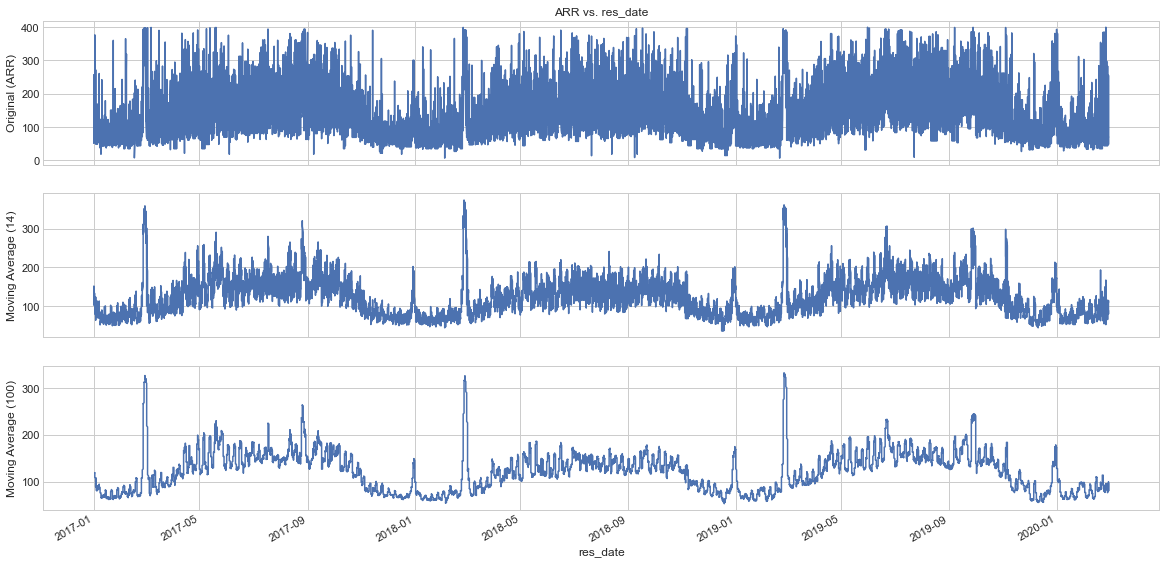

In [223]:
x = reservations_df.index.unique()
y1 = reservations_df[dependent_var].groupby(reservations_df.index).mean()
y2 = reservations_df[dependent_var].groupby(reservations_df.index).mean().rolling(window=14).mean()
y3 = reservations_df[dependent_var].groupby(reservations_df.index).mean().rolling(window=100).mean()

fig, ax = plt.subplots(3,1,figsize=(20,10), sharex=True)
ax[0].plot(x, y1)
ax[1].plot(x, y2)
ax[2].plot(x, y3)
ax[2].xaxis_date()
fig.autofmt_xdate()
ax[2].set_xlabel(index_var)
ax[0].set_ylabel('Original (%s)' % dependent_var)
ax[1].set_ylabel('Moving Average (14)')
ax[2].set_ylabel('Moving Average (100)')
ax[0].set_title('%s vs. %s' % (dependent_var,index_var))
plt.show()

### Encode the dataset

In [224]:
encoded_pre_df = reservations_df.drop([dependent_var], axis=1)

# Label Encoding:
enc_lbl = LabelEncoder()
encoded_categorical_df = encoded_pre_df.select_dtypes(include=['object']).apply(enc_lbl.fit_transform)

# OneHot Encoding:
enc_oh = OneHotEncoder(handle_unknown='ignore')
encoded_categorical_oh_df = pd.DataFrame(enc_oh.fit_transform(encoded_categorical_df).toarray(), 
                                         index=reservations_df.index)
encoded_categorical_oh_df.columns = enc_oh.get_feature_names(encoded_categorical_df.columns)

# Numerical Features:
encoded_numerical_df = encoded_pre_df.select_dtypes(exclude=['object'])

# Merge back into a single dataframe:
encoded_df = pd.concat([encoded_categorical_oh_df, encoded_numerical_df], axis=1, sort=False)
    
print('Features (after encoding):\n')
print(encoded_df.shape)
display(encoded_df.head())
display(encoded_df.describe())

Features (after encoding):

(103380, 301)


RoomTypes_desc_0  RoomTypes_desc_1  RoomTypes_desc_2  \
2017-01-01 00:00:00               0.0               1.0               0.0   
2017-01-01 00:00:01               0.0               0.0               0.0   
2017-01-01 00:00:02               0.0               0.0               0.0   
2017-01-01 00:00:03               0.0               1.0               0.0   
2017-01-01 00:00:04               0.0               1.0               0.0   

                     RoomTypes_desc_3  RoomTypes_desc_4  RoomTypes_desc_5  \
2017-01-01 00:00:00               0.0               0.0               0.0   
2017-01-01 00:00:01               0.0               0.0               1.0   
2017-01-01 00:00:02               0.0               0.0               1.0   
2017-01-01 00:00:03               0.0               0.0               0.0   
2017-01-01 00:00:04               0.0               0.0               0.0   

                     market_segment_bi_id_0  market_segment_bi_id_1  \
2017-01-01 00:00:00                     0.0                     0.0   
2017-01-01 00:00:01                     0.0                     0.0   
2017-01-01 00:00:02                     0.0                     0.0   
2017-01-01 00:00:03                     0.0                     0.0   
2017-01-01 00:00:04                     0.0                     0.0   

                     market_segment_bi_id_2  market_segment_bi_id_3  ...  \
2017-01-01 00:00:00                     0.0                     0.0  ...   
2017-01-01 00:00:01                     0.0                     0.0  ...   
2017-01-01 00:00:02                     0.0                     0.0  ...   
2017-01-01 00:00:03                     0.0                     0.0  ...   
2017-01-01 00:00:04                     0.0                     0.0  ...   

                     Demand_Barcelona  Rank_Barcelona  Demand_Madrid  \
2017-01-01 00:00:00               0.0             0.0            0.0   
2017-01-01 00:00:01               0.0             0.0            0.0   
2017-01-01 00:00:02               0.0             0.0            0.0   
2017-01-01 00:00:03               0.0             0.0            0.0   
2017-01-01 00:00:04               0.0             0.0            0.0   

                     Rank_Madrid  Hotel_Rate_Barcelona  Hotel_Rate_Madrid  \
2017-01-01 00:00:00          0.0                   0.0                0.0   
2017-01-01 00:00:01          0.0                   0.0                0.0   
2017-01-01 00:00:02          0.0                   0.0                0.0   
2017-01-01 00:00:03          0.0                   0.0                0.0   
2017-01-01 00:00:04          0.0                   0.0                0.0   

                         ma2  ma7  ma14  ma100  
2017-01-01 00:00:00    0.000  0.0   0.0    0.0  
2017-01-01 00:00:01  135.270  0.0   0.0    0.0  
2017-01-01 00:00:02  146.745  0.0   0.0    0.0  
2017-01-01 00:00:03  111.650  0.0   0.0    0.0  
2017-01-01 00:00:04   92.720  0.0   0.0    0.0  

[5 rows x 301 columns]

RoomTypes_desc_0  RoomTypes_desc_1  RoomTypes_desc_2  RoomTypes_desc_3  \
count     103380.000000     103380.000000     103380.000000     103380.000000   
mean           0.343771          0.376891          0.030238          0.114132   
std            0.474968          0.484610          0.171242          0.317973   
min            0.000000          0.000000          0.000000          0.000000   
25%            0.000000          0.000000          0.000000          0.000000   
50%            0.000000          0.000000          0.000000          0.000000   
75%            1.000000          1.000000          0.000000          0.000000   
max            1.000000          1.000000          1.000000          1.000000   

       RoomTypes_desc_4  RoomTypes_desc_5  market_segment_bi_id_0  \
count     103380.000000     103380.000000           103380.000000   
mean           0.000164          0.134804                0.016386   
std            0.012822          0.341515                0.126956   
min            0.000000          0.000000                0.000000   
25%            0.000000          0.000000                0.000000   
50%            0.000000          0.000000                0.000000   
75%            0.000000          0.000000                0.000000   
max            1.000000          1.000000                1.000000   

       market_segment_bi_id_1  market_segment_bi_id_2  market_segment_bi_id_3  \
count           103380.000000           103380.000000           103380.000000   
mean                 0.000039                0.021000                0.010640   
std                  0.006220                0.143385                0.102602   
min                  0.000000                0.000000                0.000000   
25%                  0.000000                0.000000                0.000000   
50%                  0.000000                0.000000                0.000000   
75%                  0.000000                0.000000                0.000000   
max                  1.000000                1.000000                1.000000   

       ...  Demand_Barcelona  Rank_Barcelona  Demand_Madrid    Rank_Madrid  \
count  ...     103380.000000   103380.000000  103380.000000  103380.000000   
mean   ...          0.003321        0.001194       0.003101       0.001093   
std    ...          0.048371        0.018959       0.045158       0.017377   
min    ...          0.000000        0.000000       0.000000       0.000000   
25%    ...          0.000000        0.000000       0.000000       0.000000   
50%    ...          0.000000        0.000000       0.000000       0.000000   
75%    ...          0.000000        0.000000       0.000000       0.000000   
max    ...          0.745916        0.357350       0.694546       0.404000   

       Hotel_Rate_Barcelona  Hotel_Rate_Madrid            ma2            ma7  \
count         103380.000000      103380.000000  103380.000000  103380.000000   
mean               0.643906           0.474519     127.402105     127.397788   
std                9.417734           7.083690      51.467848      46.156607   
min                0.000000           0.000000       0.000000       0.000000   
25%                0.000000           0.000000      89.140000      91.908214   
50%                0.000000           0.000000     121.060000     125.044286   
75%                0.000000           0.000000     156.850000     155.342321   
max              154.363636         126.818182     394.780000     387.404286   

                ma14          ma100  
count  103380.000000  103380.000000  
mean      127.391036     127.291431  
std        44.417825      40.518096  
min         0.000000       0.000000  
25%        92.553750      93.510200  
50%       126.213929     130.226250  
75%       155.045179     152.777825  
max       373.773571     333.011500  

[8 rows x 301 columns]

### Histogram Analysis

Dependent variable histogram

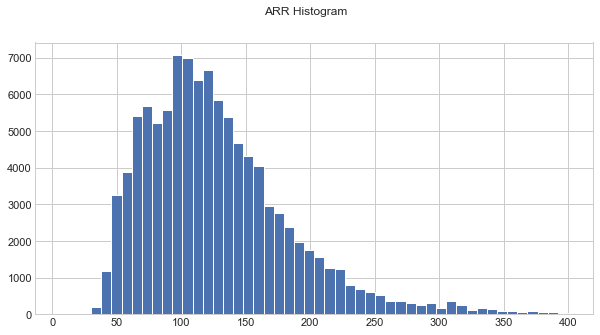

ARR min, mean, max = 6.53, 127.40, 399.98
ARR uniques (7753):
 [  6.53   6.58   7.28 ... 399.35 399.58 399.98]


In [225]:
plt.style.use('seaborn-whitegrid')
reservations_data2[dependent_var].hist(bins=50, figsize=(10,5))
plt.suptitle('%s Histogram' % dependent_var)
plt.show()

s = reservations_data2[dependent_var]
s_unique = np.sort(s.unique())
print('%s min, mean, max = %.2f, %.2f, %.2f' % (dependent_var,min(s),np.mean(s),max(s)))
print('%s uniques (%d):\n %s' % (dependent_var, len(s_unique), str(s_unique)))

Features Histograms

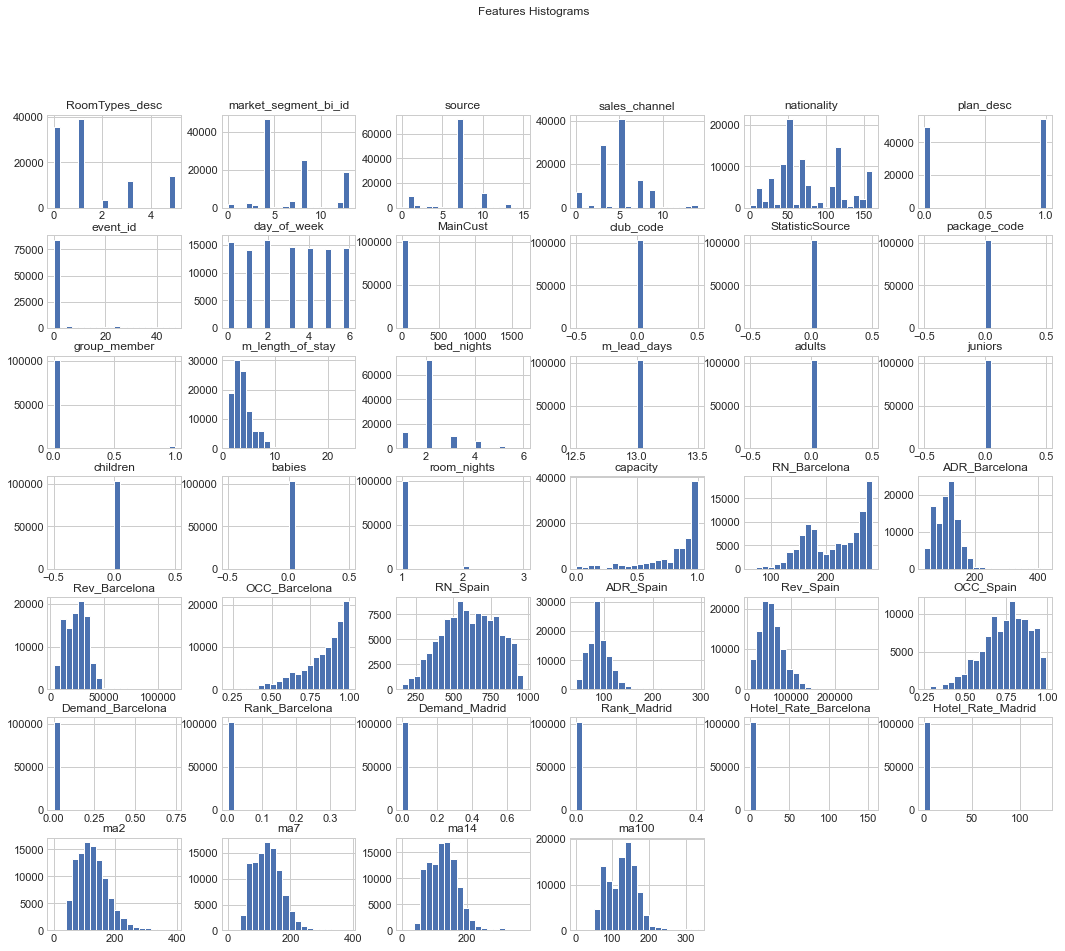

In [226]:
plt.style.use('seaborn-whitegrid')
encoded_hist_df = pd.concat([encoded_categorical_df, encoded_numerical_df], axis=1, sort=False)
encoded_hist_df.hist(bins=20, figsize=(18,15))
plt.suptitle('Features Histograms')
plt.show()

In [227]:
%%script false --no-raise-error

# Sanity check:
x = encoded_hist_df['Demand_Barcelona'].to_numpy()
x = x[x.nonzero()]
pd.Series(x).hist(bins=50)

### Correlation Matrix

A correlation matrix is a table showing correlation coefficients between variables. Each cell in the table shows the correlation between two variables.<br>
The __Pearson__ and __Spearman__ correlation coefficients can range in value from −1 to +1 ([link](https://support.minitab.com/en-us/minitab-express/1/help-and-how-to/modeling-statistics/regression/supporting-topics/basics/a-comparison-of-the-pearson-and-spearman-correlation-methods/)).<br>
The __Pearson__ correlation evaluates the __linear__ relationship between two continuous variables.<br>
The __Spearman__ correlation evaluates the __monotonic__ relationship between two continuous or ordinal variables.

In [228]:
dependent_series = reservations_df[dependent_var]
encoded_df2 = pd.concat([encoded_df, dependent_series], axis=1)

Relevant Features (Pearson):

event_id_0                 0.203940
RoomTypes_desc_5           0.210494
market_segment_bi_id_6     0.214897
market_segment_bi_id_13    0.227569
event_id_6                 0.227577
bed_nights                 0.251681
RN_Spain                   0.254531
RN_Barcelona               0.271985
RoomTypes_desc_0           0.282238
RoomTypes_desc_3           0.290692
OCC_Spain                  0.341305
Rev_Spain                  0.431298
OCC_Barcelona              0.498822
ADR_Spain                  0.559775
Rev_Barcelona              0.634438
ADR_Barcelona              0.675291
ma100                      0.685754
ma14                       0.762504
ma7                        0.798918
ma2                        0.904519
ARR                        1.000000
Name: ARR, dtype: float64 

Relevant Features (Spearman):

RoomTypes_desc_5           0.211585
market_segment_bi_id_13    0.234473
bed_nights                 0.249744
RoomTypes_desc_3           0.262058
RoomTypes_d

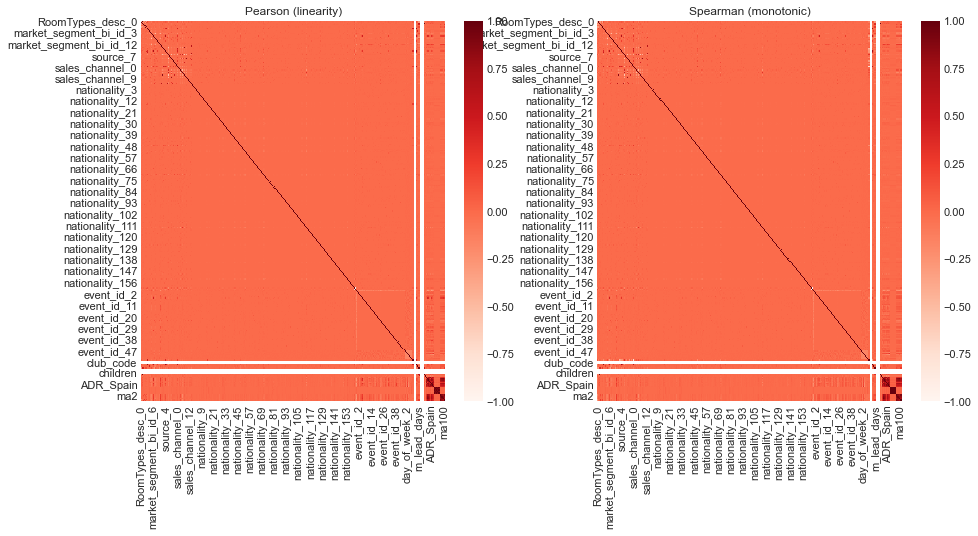

In [229]:
pearson_cor = encoded_df2.corr(method='pearson')
spearman_cor = encoded_df2.corr(method='spearman')

# Highlight relevant features
pearson_cor_targets = abs(pearson_cor[dependent_var])
spearman_cor_targets = abs(spearman_cor[dependent_var])
print('Relevant Features (Pearson):\n')
print(pearson_cor_targets[pearson_cor_targets > 0.2].sort_values(), '\n')
print('Relevant Features (Spearman):\n')
print(spearman_cor_targets[spearman_cor_targets > 0.2].sort_values())

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))
sns.heatmap(pearson_cor, ax=ax1, annot=False, cmap=plt.cm.Reds)
sns.heatmap(spearman_cor, ax=ax2, annot=False, cmap=plt.cm.Reds)
ax1.set_title('Pearson (linearity)')
ax2.set_title('Spearman (monotonic)')
plt.show()

In [230]:
%%script false --no-raise-error

plt.figure(figsize=(12,10))
ax = plt.axes()
sns.heatmap(pearson_cor, annot=True, cmap=plt.cm.Reds, ax=ax)
ax.set_title('Pearson (monotonic)')
plt.show()

plt.figure(figsize=(12,10))
ax = plt.axes()
sns.heatmap(spearman_cor, annot=True, cmap=plt.cm.Reds, ax=ax)
ax.set_title('Spearman (monotonic)')
plt.show()

<hr>

# Auxiliary Methods

In [231]:
def get_cv_scores(model, X_train, y_train):
    scores = cross_val_score(model,
                             X_train,
                             y_train,
                             cv=5,
                             scoring='r2')

    print('CV Mean Accuracy: ', np.mean(scores))
    print('CV STD Accuracy: ', np.std(scores), '\n')

In [232]:
def plot_model_results(model, X_train, X_test, y_train, y_test, y_pred):

    y_pred_train = model.predict(X_train)

    y_trn_smp = pd.DataFrame(y_train, index=X_train.index)
    y_trn_prd = pd.DataFrame(y_pred_train, index=X_train.index)
    y_tst_smp = pd.DataFrame(y_test, index=X_test.index)
    y_tst_prd = pd.DataFrame(y_pred, index=X_test.index)

    y_trn_smp_ma = y_trn_smp.groupby(y_trn_smp.index).mean().rolling(window=14).mean().fillna(0)
    y_trn_prd_ma = y_trn_prd.groupby(y_trn_prd.index).mean().rolling(window=14).mean().fillna(0)
    y_tst_smp_ma = y_tst_smp.groupby(y_tst_smp.index).mean().rolling(window=14).mean().fillna(0)
    y_tst_prd_ma = y_tst_prd.groupby(y_tst_prd.index).mean().rolling(window=14).mean().fillna(0)
    
    y_trn_ma = pd.concat([y_trn_smp_ma, y_trn_prd_ma], axis=1)
    y_trn_ma.columns = ['Sampled', 'Predicted']
    
    y_tst_ma = pd.concat([y_tst_smp_ma, y_tst_prd_ma], axis=1)
    y_tst_ma.columns = ['Sampled', 'Predicted']    
    
    # Figure 1:
    plt.figure(figsize=(20,12))
    
    plt.subplot(221)
    plt.scatter(y_train, y_pred_train)
    plt.plot(y_train, y_train, color='red', linewidth=1, linestyle='dashed')    
    plt.title('Train-Set')
    plt.xlabel('Sampled')
    plt.ylabel("Predicted")

    plt.subplot(222)
    plt.scatter(y_test, y_pred)
    plt.plot(y_test, y_test, color='red', linewidth=1, linestyle='dashed')    
    plt.title('Test-Set')
    plt.xlabel('Sampled')
    plt.ylabel("Predicted")

    plt.show()
    
    # Figure 2:
    fig, ax = plt.subplots(1, 2, figsize=(20,6))
    y_trn_ma.plot(ax=ax[0], linewidth=1)
    ax[0].xaxis_date()
    ax[0].set_title('Train-Set - Sampled vs. Predicted (MA=14)')
    ax[0].set_xlabel('Time')
    ax[0].legend()

    y_tst_ma.plot(ax=ax[1], linewidth=1)
    ax[1].xaxis_date()
    ax[1].set_title('Test-Set - Sampled vs. Predicted (MA=14)')
    ax[1].set_xlabel('Time')
    ax[1].legend()

    fig.autofmt_xdate()

    plt.show()

In [233]:
def plot_tree_features_importance(feature_importances, feature_labels, threshold):
    feature_import_val = feature_importances[feature_importances > threshold]
    feature_import_lbl = feature_labels[feature_importances > threshold]

    plt.figure(figsize=(12,6))
    plt.bar(feature_import_lbl, feature_import_val)
    plt.xticks(rotation='vertical')
    plt.title('Features Importance')
    plt.show()

In [234]:
def plot_permutation_importance(model, X, y, topN, n_repeats=10, random_state=42):
    result = permutation_importance(model, X, y, n_repeats=10, random_state=42)
    perm_sorted_idx = result.importances_mean.argsort()

    feature_import_val = result.importances[perm_sorted_idx].T[:,-topN:]
    feature_import_lbl = X.columns[perm_sorted_idx][-topN:]

    plt.figure(figsize=(12,6))
    plt.boxplot(feature_import_val, vert=False, labels=feature_import_lbl)
    plt.xticks(rotation='vertical')
    plt.title('Permutation Importance')
    plt.show()

In [235]:
def plot_partial_dependencies(model, X, target_features):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_title("Partial Dependencies")
    plot_partial_dependence(model, X, target_features, ax=ax, line_kw={"c": "red"})

In [236]:
def plot_partial_2d_dependencies(model, X, target_feature1, target_feature2):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_title("Partial Dependencies, 2D")
    plot_partial_dependence(model, 
                            X,
                            [(list(X.columns).index(target_feature1),
                              list(X.columns).index(target_feature2))],
                            n_jobs=3,
                            grid_resolution=20,
                            ax=ax)

In [237]:
def plot_learning_curve(history):

    fig, axes = plt.subplots(1, 1, figsize=(20,10))
    axes.plot(history['loss'], 'b', label='Train', linewidth=2)
    axes.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
    axes.set_title('Learning Curve', fontsize=20)
    axes.set_ylabel('Loss (mae)', fontsize=15)
    axes.set_xlabel('Epoch', fontsize=15)
    axes.legend(loc='upper right')
    plt.show()

In [238]:
def print_model_accuracy(model, X_train, y_train, X_test, y_test):
    score_trn = model.score(X_train, y_train) if abs(model.score(X_train, y_train))<=1 else 0
    score_tst = model.score(X_test, y_test) if abs(model.score(X_test, y_test))<=1 else 0
    print('Train Accuracy: ', score_trn)
    print('Test Accuracy: ', score_tst)

<hr>

# Basic Modelling

Linear Modelling:

![](https://miro.medium.com/max/1400/1*0W935wbGEcLZoqXIxkuhTQ.png)

### Normalization

In [239]:
scaler = MinMaxScaler if scaling_mode == "minmax" else StandardScaler()
encoded_scl_df = pd.DataFrame(scaler.fit_transform(encoded_df), 
                              index=encoded_df.index,
                              columns=encoded_df.columns)

encoded_scl_df.describe()

RoomTypes_desc_0  RoomTypes_desc_1  RoomTypes_desc_2  RoomTypes_desc_3  \
count      1.033800e+05      1.033800e+05      1.033800e+05      1.033800e+05   
mean       3.079156e-17     -1.605560e-16      2.199397e-18      7.148041e-18   
std        1.000005e+00      1.000005e+00      1.000005e+00      1.000005e+00   
min       -7.237798e-01     -7.777248e-01     -1.765809e-01     -3.589384e-01   
25%       -7.237798e-01     -7.777248e-01     -1.765809e-01     -3.589384e-01   
50%       -7.237798e-01     -7.777248e-01     -1.765809e-01     -3.589384e-01   
75%        1.381636e+00      1.285802e+00     -1.765809e-01     -3.589384e-01   
max        1.381636e+00      1.285802e+00      5.663128e+00      2.785993e+00   

       RoomTypes_desc_4  RoomTypes_desc_5  market_segment_bi_id_0  \
count      1.033800e+05      1.033800e+05            1.033800e+05   
mean      -2.336859e-18      1.033717e-16           -5.058613e-17   
std        1.000005e+00      1.000005e+00            1.000005e+00   
min       -1.282454e-02     -3.947239e-01           -1.290702e-01   
25%       -1.282454e-02     -3.947239e-01           -1.290702e-01   
50%       -1.282454e-02     -3.947239e-01           -1.290702e-01   
75%       -1.282454e-02     -3.947239e-01           -1.290702e-01   
max        7.797549e+01      2.533416e+00            7.747719e+00   

       market_segment_bi_id_1  market_segment_bi_id_2  market_segment_bi_id_3  \
count            1.033800e+05            1.033800e+05            1.033800e+05   
mean            -3.299096e-18            6.873116e-18            7.917830e-17   
std              1.000005e+00            1.000005e+00            1.000005e+00   
min             -6.220426e-03           -1.464604e-01           -1.037053e-01   
25%             -6.220426e-03           -1.464604e-01           -1.037053e-01   
50%             -6.220426e-03           -1.464604e-01           -1.037053e-01   
75%             -6.220426e-03           -1.464604e-01           -1.037053e-01   
max              1.607607e+02            6.827782e+00            9.642708e+00   

       ...  Demand_Barcelona  Rank_Barcelona  Demand_Madrid   Rank_Madrid  \
count  ...      1.033800e+05    1.033800e+05   1.033800e+05  1.033800e+05   
mean   ...     -1.374623e-17    5.388523e-17  -5.498493e-18  3.299096e-17   
std    ...      1.000005e+00    1.000005e+00   1.000005e+00  1.000005e+00   
min    ...     -6.866315e-02   -6.298675e-02  -6.867476e-02 -6.287487e-02   
25%    ...     -6.866315e-02   -6.298675e-02  -6.867476e-02 -6.287487e-02   
50%    ...     -6.866315e-02   -6.298675e-02  -6.867476e-02 -6.287487e-02   
75%    ...     -6.866315e-02   -6.298675e-02  -6.867476e-02 -6.287487e-02   
max    ...      1.535225e+01    1.878573e+01   1.531172e+01  2.318606e+01   

       Hotel_Rate_Barcelona  Hotel_Rate_Madrid           ma2           ma7  \
count          1.033800e+05       1.033800e+05  1.033800e+05  1.033800e+05   
mean           3.299096e-18      -1.924472e-17 -2.199397e-16 -2.771240e-16   
std            1.000005e+00       1.000005e+00  1.000005e+00  1.000005e+00   
min           -6.837195e-02      -6.698793e-02 -2.475385e+00 -2.760134e+00   
25%           -6.837195e-02      -6.698793e-02 -7.434212e-01 -7.688985e-01   
50%           -6.837195e-02      -6.698793e-02 -1.232252e-01 -5.098975e-02   
75%           -6.837195e-02      -6.698793e-02  5.721638e-01  6.054316e-01   
max            1.632245e+01       1.783594e+01  5.195072e+00  5.633164e+00   

               ma14         ma100  
count  1.033800e+05  1.033800e+05  
mean   8.797589e-17  3.870939e-16  
std    1.000005e+00  1.000005e+00  
min   -2.868030e+00 -3.141610e+00  
25%   -7.843125e-01 -8.337360e-01  
50%   -2.650092e-02  7.243266e-02  
75%    6.225941e-01  6.290157e-01  
max    5.546956e+00  5.077264e+00  

[8 rows x 301 columns]

### Cross Validation (Train/Test split)

R-squared (R²), Mean Squared Error (MSE), Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE) are the most commonly used metrics to measure accuracy for continuous variables.<br>
The focus here is on R-Squared, aka the coefficient of determination, which implies how much variance in the target variable can be explained by the model.<br>
Values can range from 0 to 1. Higher values indicate a model that is highly predictive.<br>
For example, a R² value of 0.80 means that the model is accounting for 80% of the variability in the data.<br>
In general, the higher the R² value the better. However, a very high R² could be a sign of overfitting. <br>
Low values indicate that our model is not very good at predicting the target.<br>

<div><img src="https://miro.medium.com/max/2000/1*RZ7wWxTZxb6ySGGWJaY-CQ.jpeg" width=800"/></div>

Split the data into training and testing with a ratio of 80% and 20%

In [240]:
X_train, X_test, y_train, y_test = train_test_split(encoded_scl_df, 
                                                    dependent_series, 
                                                    test_size=cv_ratio, 
                                                    random_state=27,
                                                    shuffle=False)   # essential for TimeSeries

X_train = X_train.sort_index()
X_test = X_test.sort_index()
y_train = y_train.sort_index()
y_test = y_test.sort_index()

X_train.index = X_train.index.rename(index_var)
X_test.index = X_test.index.rename(index_var)
y_train.index = y_train.index.rename(index_var)
y_test.index = y_test.index.rename(index_var)

Prepare a combined Xy version as well

In [241]:
scaler_xy_train = MinMaxScaler if scaling_mode == "minmax" else StandardScaler()
scaler_xy_test = MinMaxScaler if scaling_mode == "minmax" else StandardScaler()

Xy_train = X_train.copy()
Xy_train[dependent_var] = y_train.values
Xy_train = pd.DataFrame(scaler_xy_train.fit_transform(Xy_train),
                        index=Xy_train.index,
                        columns=Xy_train.columns)

Xy_test = X_test.copy()
Xy_test[dependent_var] = y_test.values
Xy_test = pd.DataFrame(scaler_xy_test.fit_transform(Xy_test),
                       index=Xy_test.index,
                       columns=Xy_test.columns)

<hr>

### Linear Regressor

Linear regression finds the parameters to minimize the mean squared error or residuals between the predictions and the targets.<br>

<div><img src="https://gohantimes.com/wp-content/uploads/2019/11/ols-sum-of-square-diff.png" width="500"/></div>

Model: linear_regressor
CV Mean Accuracy:  -1.7183669904642892e+25
CV STD Accuracy:  1.2042993284942094e+25 

Train Accuracy:  0.7810327660163229
Test Accuracy:  0


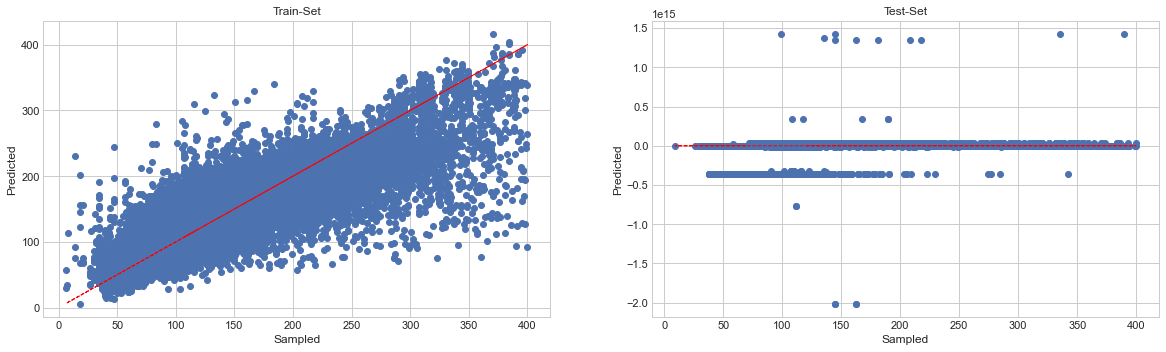

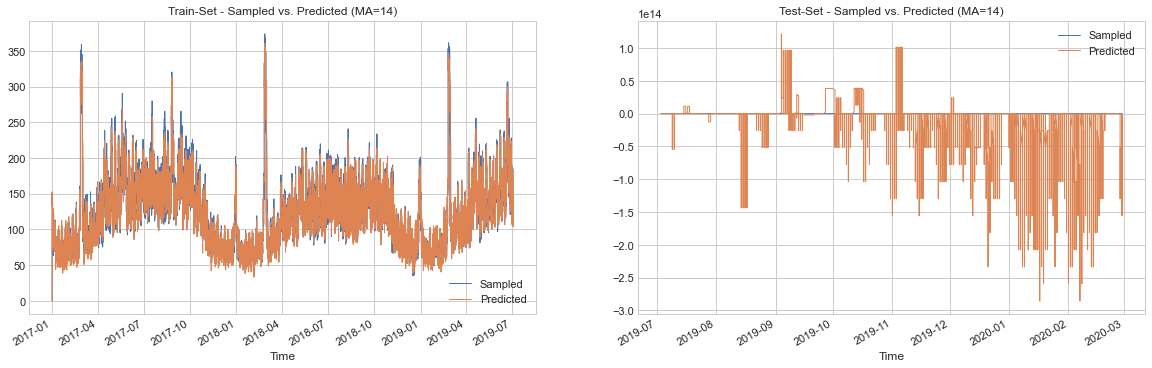

In [148]:
model_name = models[0]
print('Model: %s' % model_name)
model_file = save_path + "model_%s_h%d.pkl" % (model_name, hotel_sel)

if path.isfile(model_file) and not overwrite_saved_data:
    
    # Load an existing model
    model = joblib.load(model_file)

else:
    
    # Create object
    model = LinearRegression(n_jobs=4)

    # Train the model using the training sets
    model = model.fit(X_train, y_train)

    # Save the model
    joblib.dump(model, model_file) 

    # Get cross validation scores
    get_cv_scores(model, X_train, y_train)

print_model_accuracy(model, X_train, y_train, X_test, y_test)
    
# Make predictions using the testing set
y_pred = model.predict(X_test)

# Plot
plot_model_results(model, X_train, X_test, y_train, y_test, y_pred)

Examine the coefficients:

In [149]:
for coef, col in enumerate(X_train.columns[:10]):
    print('%s --> %.2f' % (col, model.coef_[coef]))

RoomTypes_desc_0 --> 97778197583851.62
RoomTypes_desc_1 --> 99749972178028.86
RoomTypes_desc_2 --> 35254413218722.27
RoomTypes_desc_3 --> 65461886398319.41
RoomTypes_desc_4 --> 2639834659299.00
RoomTypes_desc_5 --> 70308290773760.02
market_segment_bi_id_0 --> -5943334128890.16
market_segment_bi_id_1 --> -293072546108.25
market_segment_bi_id_2 --> -6755751693817.87
market_segment_bi_id_3 --> -42129936339198.80


<hr>

### Ridge Regressor

Ridge regression uses L2 regularization to minimize the magnitude of the coefficients.<br>
It reduces the size of the coefficients and helps reduce model complexity.<br>
We control the complexity of our model with the regularization parameter, ⍺.<br>
Higher values of ⍺ force coefficients to move towards zero and increases the restriction on the model.<br>
This decreases training performance, but also increases the generalizability of the model. 

Model: ridge_regressor
CV Mean Accuracy:  0.7609068409275246
CV STD Accuracy:  0.03353463048428944 

Train Accuracy:  0.781077195559099
Test Accuracy:  0.7303526708660171


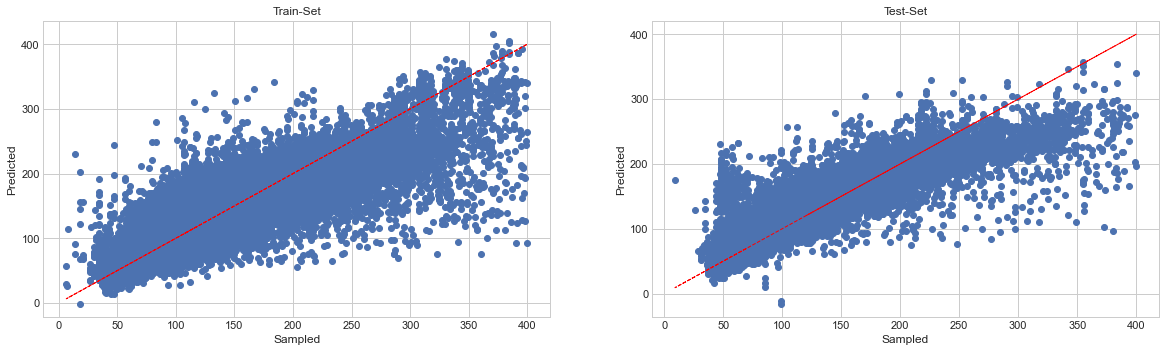

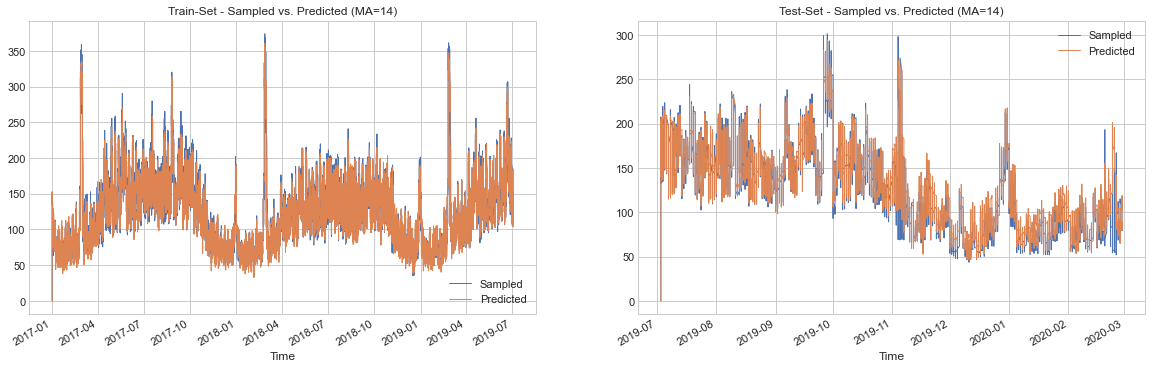

In [150]:
model_name = models[1]
print('Model: %s' % model_name)
model_file = save_path + "model_%s_h%d.pkl" % (model_name, hotel_sel)

if path.isfile(model_file) and not overwrite_saved_data:
    
    # Load an existing model
    model = joblib.load(model_file)

else:
    
    # Create object
    model = Ridge(alpha=0.1)

    # Hyper-Parameters optimization:
    if hyper_params_en:

        model = GridSearchCV(model,
                             {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
                             scoring='r2', 
                             verbose=1,
                             n_jobs=1).estimator

    # Train the model using the training sets
    model.fit(X_train, y_train)

    # Save the model
    joblib.dump(model, model_file)    
    
    # Get cross validation scores
    get_cv_scores(model, X_train, y_train)

print_model_accuracy(model, X_train, y_train, X_test, y_test)
    
# Make predictions using the testing set
y_pred = model.predict(X_test)

# Plot
plot_model_results(model, X_train, X_test, y_train, y_test, y_pred)

#### Plot Partial Dependencies (PDP)
Partial dependence plots (PDP) show the dependence between the target response and a set of ‘target’ features, marginalizing over the values of all other features (the ‘complement’ features). Intuitively, we can interpret the partial dependence as the expected target response as a function of the ‘target’ features.<br> X-axis represents the 'target feature', while y-axis represents the model prediction.<br>
[reference](https://www.kaggle.com/dansbecker/partial-dependence-plots)

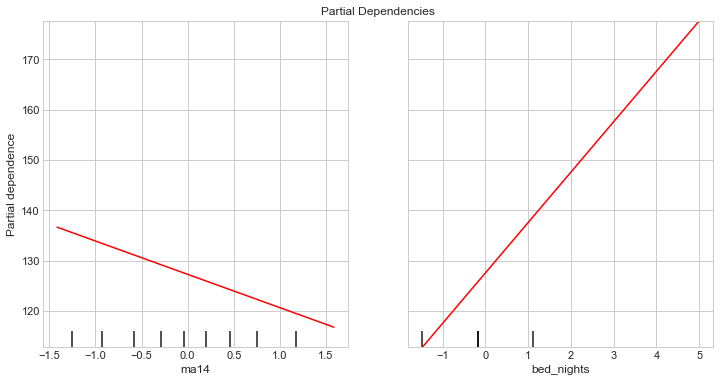

In [151]:
plot_partial_dependencies(model, X_train, ["ma14", "bed_nights"])

We can clearly see a linear relationship among these featrues.<br>
Note that PDPs assume that the target features are independent from the complement features, and this assumption is often violated in practice.

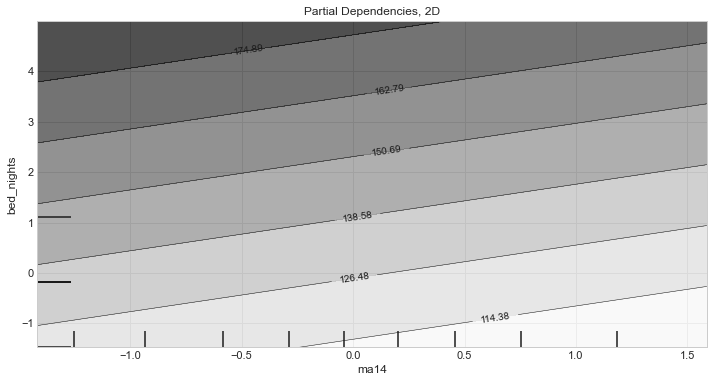

In [152]:
plot_partial_2d_dependencies(model, X_train, "ma14", "bed_nights")

#### Permutation Importance
“Permutation importance” is model-agnostic variable importance approach, so they do not require a single variable-related discrete training process like decision tree. The permutation feature importance is defined to be the decrease in a model score when a single feature value is randomly shuffled.<br>
[reference](https://scikit-learn.org/stable/modules/permutation_importance.html)

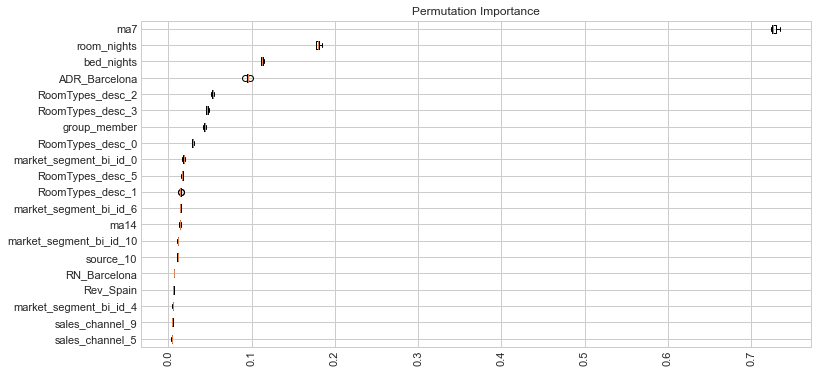

In [153]:
plot_permutation_importance(model, X_test, y_test, 20)

<hr>

### Lasso Regressor

Lasso regression uses L1 regularization to force some coefficients to be exactly zero.<br>
This means some features are completely ignored by the model. <br>
This can be thought of as a type of automatic feature selection!<br>
Lasso can be a good model choice when we have a large number of features but expect only a few to be important.<br>
Higher values of ⍺ force more coefficients to zero and can cause underfitting.<br>
Lower values of alpha lead to fewer non-zero features and can cause overfitting.<br>
Very low values of alpha will cause the model to resemble linear regression.

Model: lasso_regressor
CV Mean Accuracy:  0.7611908783262908
CV STD Accuracy:  0.03481363730881683 

Train Accuracy:  0.7794578898791702
Test Accuracy:  0.7346887084600647


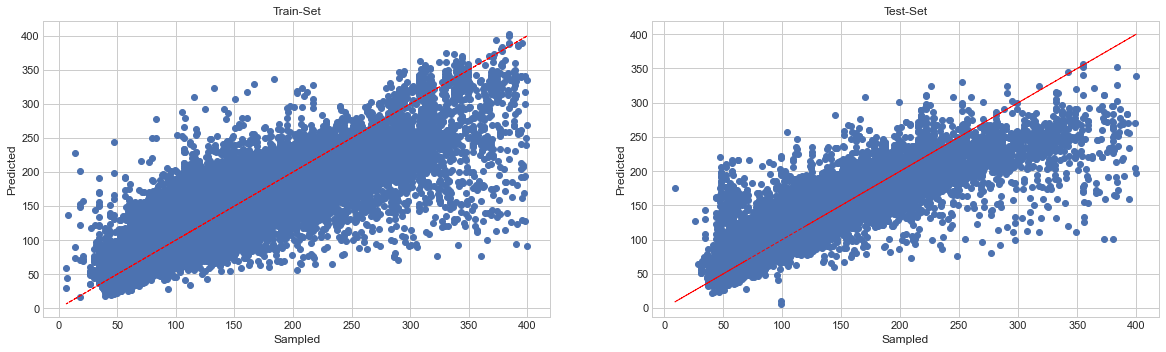

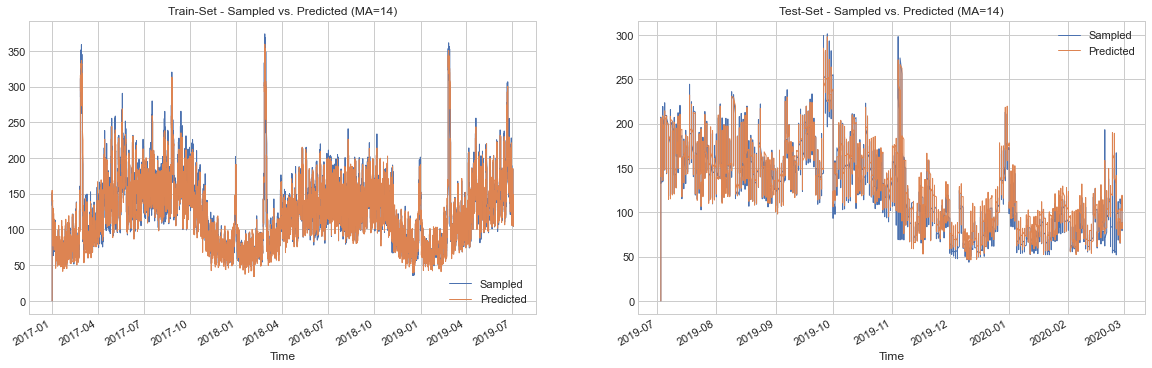

In [154]:
model_name = models[2]
print('Model: %s' % model_name)
model_file = save_path + "model_%s_h%d.pkl" % (model_name, hotel_sel)

if path.isfile(model_file) and not overwrite_saved_data:
    
    # Load an existing model
    model = joblib.load(model_file)

else:

    # Create object
    model = Lasso(alpha=0.1)

    # Hyper-Parameters optimization:
    if hyper_params_en:

        model = GridSearchCV(model,
                             {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
                             scoring='r2', 
                             verbose=1,
                             n_jobs=1).estimator

    # Train the model using the training sets
    model.fit(X_train, y_train)

    # Save the model
    joblib.dump(model, model_file)
    
    # Get cross validation scores
    get_cv_scores(model, X_train, y_train)

print_model_accuracy(model, X_train, y_train, X_test, y_test)
    
# Make predictions using the testing set
y_pred = model.predict(X_test)

# Plot
plot_model_results(model, X_train, X_test, y_train, y_test, y_pred)

<hr>

### Elastic-Net Regressor

Elastic-net is a linear regression model that combines the penalties of Lasso (L1) and Ridge (L2).<br>

<div><img src="https://miro.medium.com/max/1312/1*oECWmvwOKotaAA0czR30vg.png" width="500"/></div>

Model: elasticnet_regressor
CV Mean Accuracy:  0.721464806224842
CV STD Accuracy:  0.04693467022816869 

Train Accuracy:  0.7397034033812517
Test Accuracy:  0.689122706591218


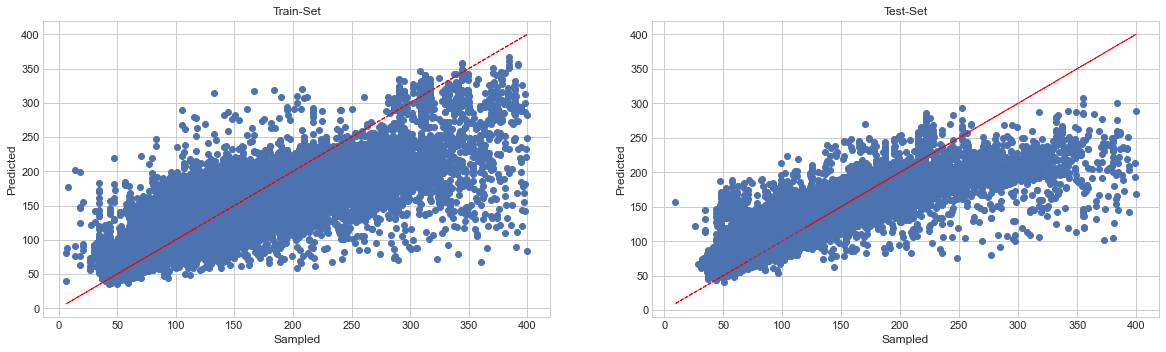

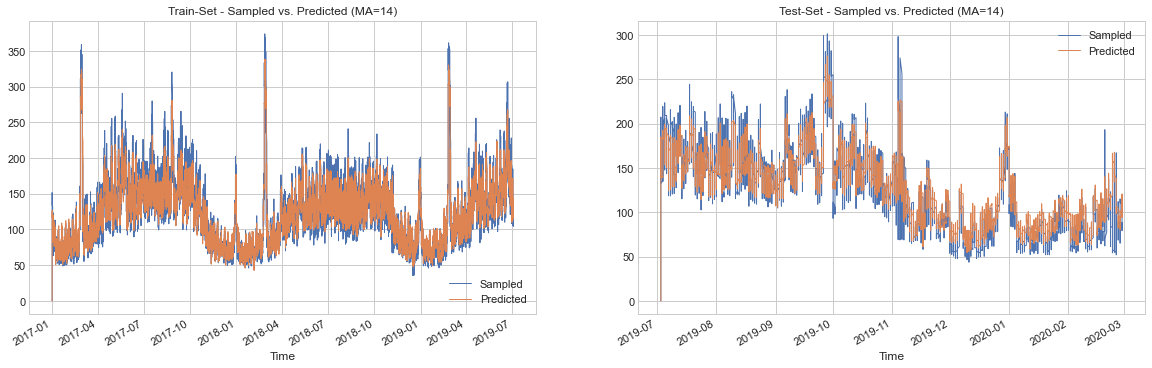

In [155]:
model_name = models[3]
print('Model: %s' % model_name)
model_file = save_path + "model_%s_h%d.pkl" % (model_name, hotel_sel)

if path.isfile(model_file) and not overwrite_saved_data:
    
    # Load an existing model
    model = joblib.load(model_file)

else:

    # Create object
    model = ElasticNet(alpha=1, l1_ratio=0.5)

    # Hyper-Parameters optimization:
    if hyper_params_en:

        model = GridSearchCV(model,
                             {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                              'l1_ratio': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]}, 
                             scoring='r2', 
                             verbose=1,
                             n_jobs=1).estimator

    # Train the model using the training sets
    model.fit(X_train, y_train)
    
    # Save the model
    joblib.dump(model, model_file)

    # Get cross validation scores
    get_cv_scores(model, X_train, y_train)

print_model_accuracy(model, X_train, y_train, X_test, y_test)

# Make predictions using the testing set
y_pred = model.predict(X_test)

# Plot
plot_model_results(model, X_train, X_test, y_train, y_test, y_pred)

### Support Vector Regressor

The method of Support Vector Classification can be extended to solve regression problems, termed as Support Vector Regression.<br>
The model produced by support vector classification (classic SVM) depends only on a subset of the training data, because the cost function for building the model does not care about training points that lie beyond the margin.<br>
Analogously, the model produced by Support Vector Regression depends only on a subset of the training data, because the cost function for building the model ignores any training data close to the model prediction.<br>
In simple regression we try to minimise the error rate. While in SVR we try to fit the error within a certain threshold<br>

<div><img src="https://miro.medium.com/max/1400/1*rs0EfF8RPVpgA-EfgAq85g.jpeg" width="500"/></div>

Model: supportvect_regressor


Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.


CV Mean Accuracy:  0.021169699476857762
CV STD Accuracy:  0.2011116561095852 

Train Accuracy:  0.7763537831207051
Test Accuracy:  0


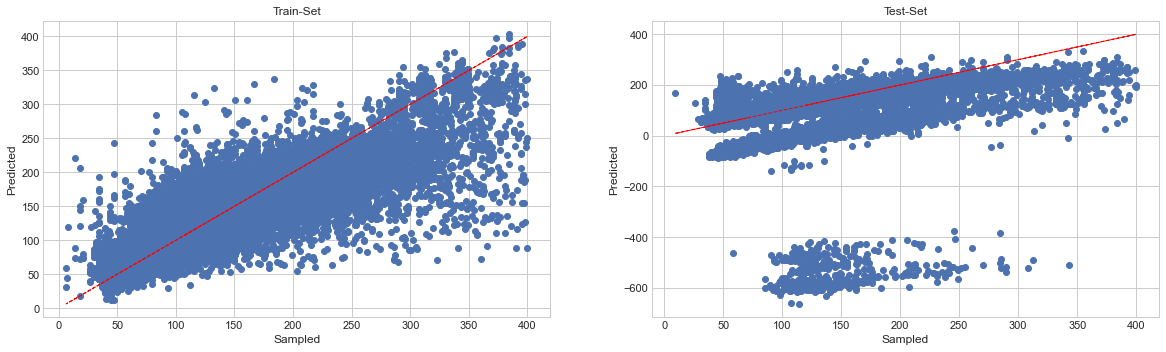

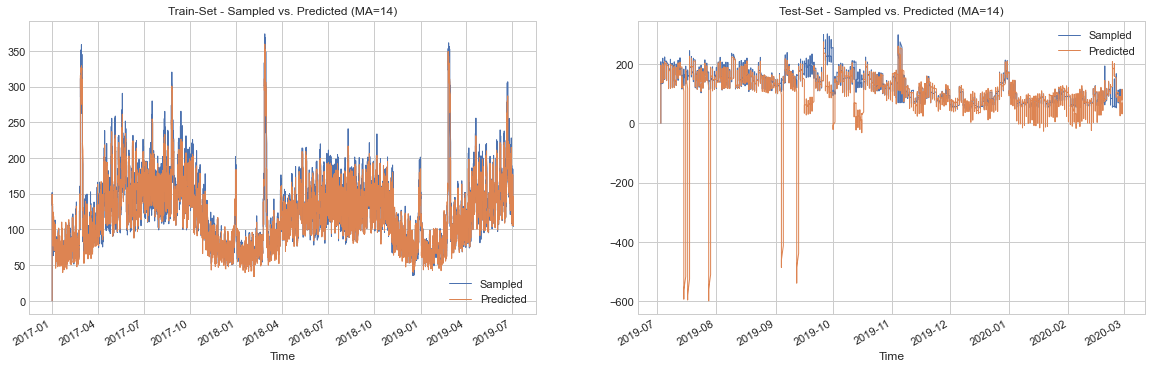

In [156]:
model_name = models[4]
print('Model: %s' % model_name)
model_file = save_path + "model_%s_h%d.pkl" % (model_name, hotel_sel)

if path.isfile(model_file) and not overwrite_saved_data:
    
    # Load an existing model
    model = joblib.load(model_file)

else:

    # Create object
    model = LinearSVR(random_state=0, tol=1e-5)

    # Train the model using the training sets
    model = model.fit(X_train, y_train)

    # Save the model
    joblib.dump(model, model_file) 
    
    # Get cross validation scores
    get_cv_scores(model, X_train, y_train)

print_model_accuracy(model, X_train, y_train, X_test, y_test)

# Make predictions using the testing set
y_pred = model.predict(X_test)

# Plot
plot_model_results(model, X_train, X_test, y_train, y_test, y_pred)

<hr>

# Trees

### Decision Tree Regressor

<div><img src="https://miro.medium.com/max/1630/1*XZ220vTa7rN8ccJZZNe09w.png" width="500"/></div>

Model: decisiontree_regressor
CV Mean Accuracy:  0.45700002056331324
CV STD Accuracy:  0.11555174027275548 

Train Accuracy:  0.9999980513698558
Test Accuracy:  0.5324973918048508


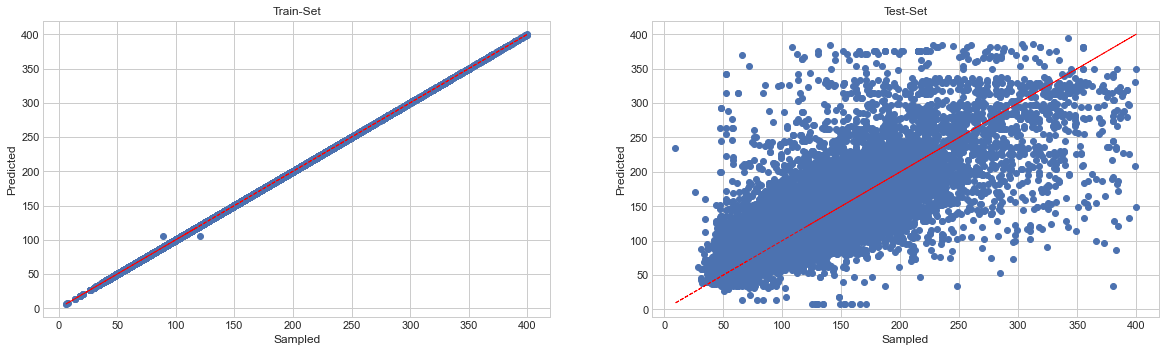

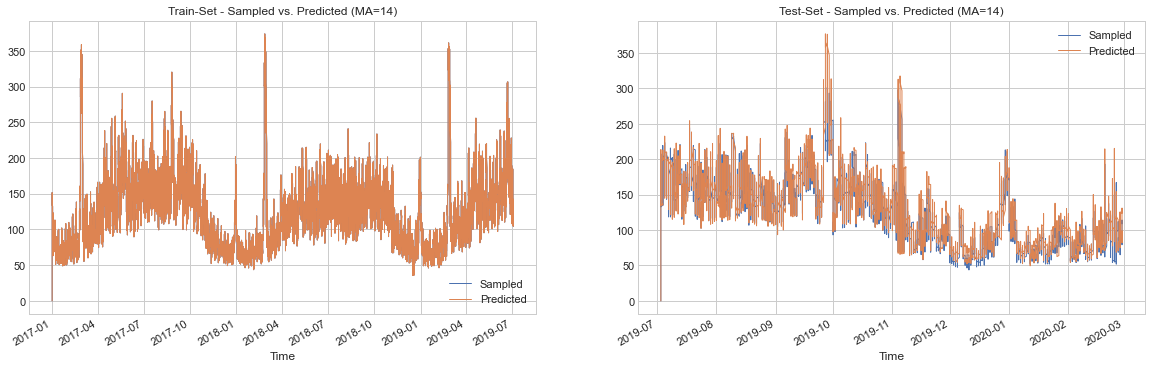

In [157]:
model_name = models[5]
print('Model: %s' % model_name)
model_file = save_path + "model_%s_h%d.pkl" % (model_name, hotel_sel)

if path.isfile(model_file) and not overwrite_saved_data:
    
    # Load an existing model
    model = joblib.load(model_file)

else:

    # Create object
    model = DecisionTreeRegressor(random_state=0)

    # Train the model using the training sets
    model.fit(X_train, y_train)

    # Save the model
    joblib.dump(model, model_file)
    
    # Get cross validation scores
    get_cv_scores(model, X_train, y_train)

print_model_accuracy(model, X_train, y_train, X_test, y_test)
    
# Make predictions using the testing set
y_pred = model.predict(X_test)

# Plot
plot_model_results(model, X_train, X_test, y_train, y_test, y_pred)

Feature Importances

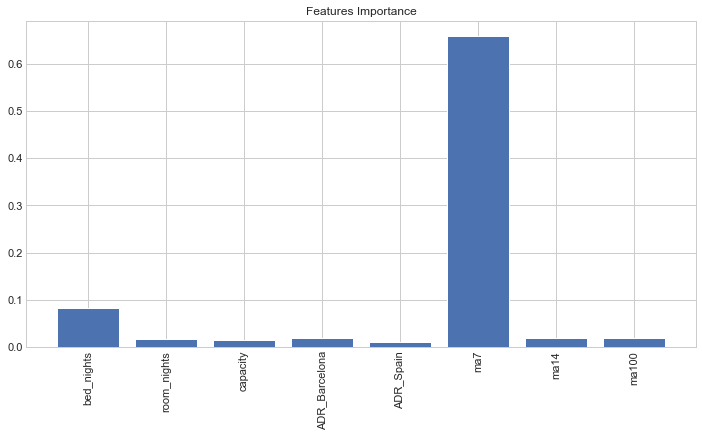

In [158]:
plot_tree_features_importance(model.feature_importances_, X_train.columns, 0.01)

Tree Visualization

In [159]:
%%script false --no-raise-error

plot_tree(model)

<hr>

### Random Forest Regressor

A random forest is a meta estimator that fits a number of classifying decision trees on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting<br>

<div><img src="https://databricks.com/wp-content/uploads/2015/01/Ensemble-example.png" width="500"/></div>

Model: randomforest_regressor
CV Mean Accuracy:  0.5552886518351509
CV STD Accuracy:  0.07194262807926947 

Train Accuracy:  0.585511574935546
Test Accuracy:  0.5535243764338973


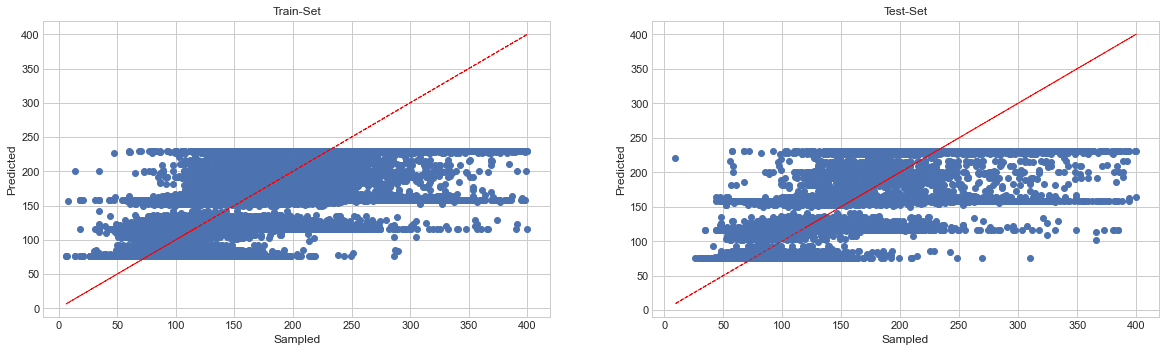

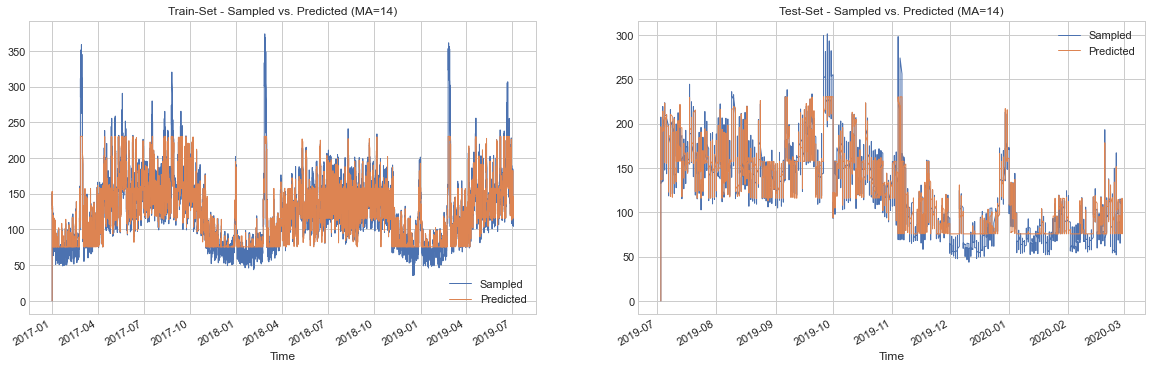

In [160]:
model_name = models[6]
print('Model: %s' % model_name)
model_file = save_path + "model_%s_h%d.pkl" % (model_name, hotel_sel)

if path.isfile(model_file) and not overwrite_saved_data:
    
    # Load an existing model
    model = joblib.load(model_file)

else:

    # Create object
    model = RandomForestRegressor(max_depth=2, random_state=0)

    # Train the model using the training sets
    model.fit(X_train, y_train)

    # Save the model
    joblib.dump(model, model_file)
    
    # Get cross validation scores
    get_cv_scores(model, X_train, y_train)

print_model_accuracy(model, X_train, y_train, X_test, y_test)
    
# Make predictions using the testing set
y_pred = model.predict(X_test)

# Plot
plot_model_results(model, X_train, X_test, y_train, y_test, y_pred)

Feature Importances

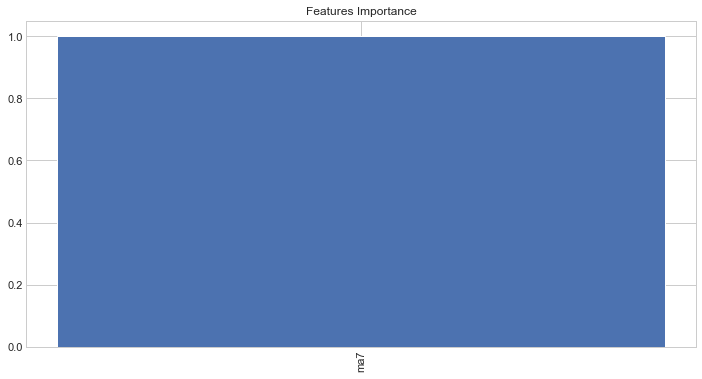

In [161]:
plot_tree_features_importance(model.feature_importances_, X_train.columns, 0.01)

<hr>

### XGBoost Regressor

XGBoost stands for “Extreme Gradient Boosting”, where the term “Gradient Boosting” originates from the paper Greedy Function Approximation: A Gradient Boosting Machine, by Friedman.<br>

<div><img src="https://miro.medium.com/max/1000/0*tzKt_ABz5rRrsGoW.jpg" width="500"/></div>

Model: xgboost_regressor
CV Mean Accuracy:  0.8658397840865977
CV STD Accuracy:  0.021052812832600375 

Train Accuracy:  0.894681793546742
Test Accuracy:  0.8578279735420797


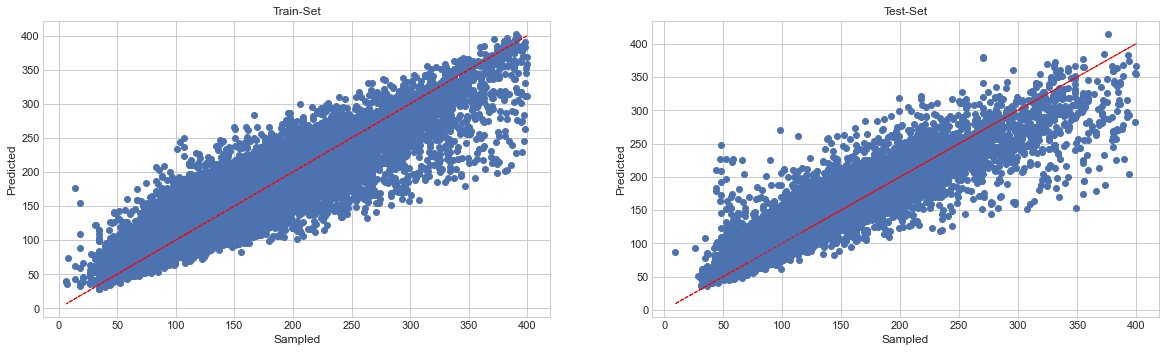

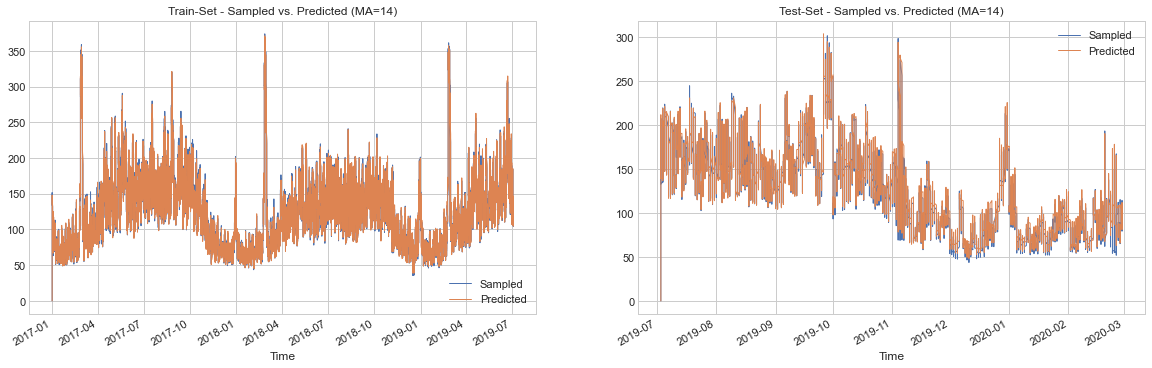

Base Score:  None


In [242]:
model_name = models[7]
print('Model: %s' % model_name)
model_file = save_path + "model_%s_h%d.pkl" % (model_name, hotel_sel)

if path.isfile(model_file) and not overwrite_saved_data:
    
    # Load an existing model
    model = joblib.load(model_file)

else:
    
    # Create object
    model = xgb.XGBRegressor(objective='reg:squarederror', max_depth=4, n_estimators=100)

    # Hyper-Parameters optimization:
    if hyper_params_en:

        model = GridSearchCV(model,
                             {'max_depth': [2,4,6],
                              'n_estimators': [50,100,200]}, 
                             verbose=1,
                             n_jobs=1).estimator

    # Train the model using the training sets
    model.fit(X_train, y_train)
    
    # Save the model
    joblib.dump(model, model_file)

    # Get cross validation scores
    get_cv_scores(model, X_train, y_train)
    
print_model_accuracy(model, X_train, y_train, X_test, y_test)
    
# Make predictions using the testing set
y_pred = model.predict(X_test)

# Plot
plot_model_results(model, X_train, X_test, y_train, y_test, y_pred)

print('Base Score: ', model.base_score)

Feature Importances

Text(0.5, 1.0, 'Features Importance')

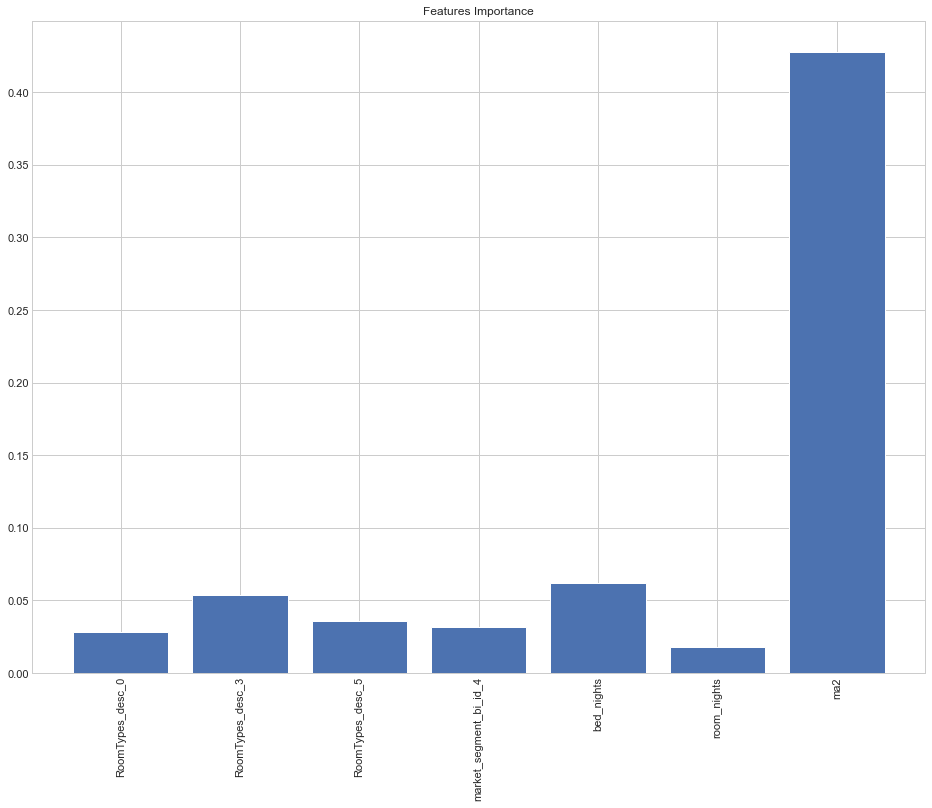

In [243]:
feature_import_thr = 0.01
feature_import_val = model.feature_importances_[model.feature_importances_ > feature_import_thr]
feature_import_lbl = X_train.columns[model.feature_importances_ > feature_import_thr]

plt.figure(figsize=(16,12))
plt.bar(feature_import_lbl, feature_import_val)
plt.xticks(rotation='vertical')
plt.title('Features Importance')

__Partial Dependency Plot (PDP)__ - create a dependence plot to show the effect of a single feature across the whole dataset ([reference](https://shap.readthedocs.io/en/latest/))

A dependence plot is a scatter plot that shows the effect a single feature has on the predictions made by the model.

- Each dot is a single prediction (row) from the dataset.
- The x-axis is the value of the feature on-focus
- The y-axis is the SHAP value for that feature, represents how much knowing that feature's value changes model's output for that sample's prediction
- The color corresponds to a second feature that may have an interaction effect with the feature we are plotting (chosen automatically by default). If an interaction effect is present between this other feature and the feature we are plotting it will show up as a distinct vertical pattern of coloring.

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


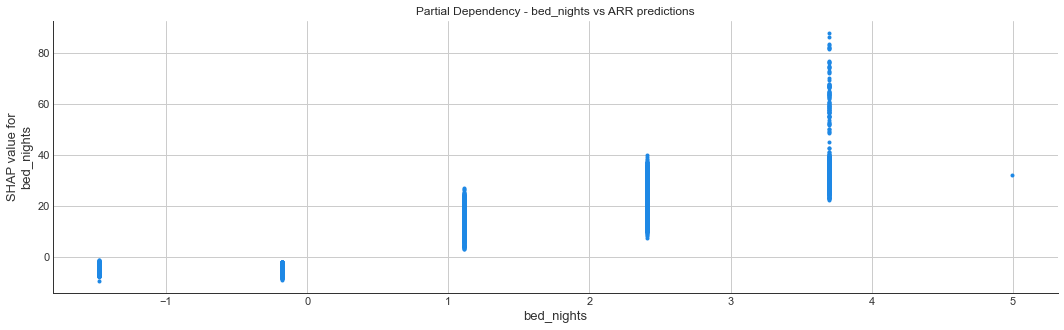

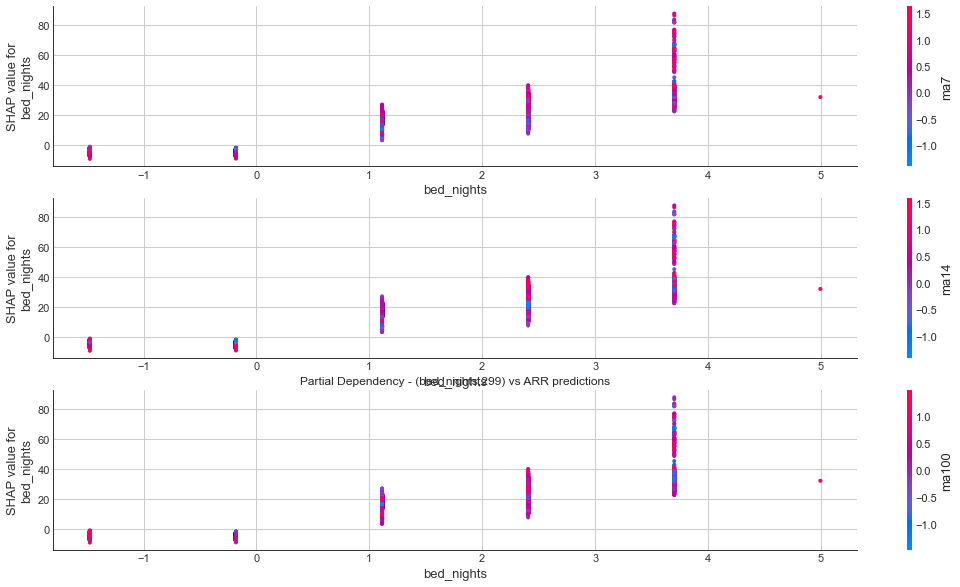

In [164]:
feature_id = 'bed_nights'

# Create object that can calculate shap values (SHapley Additive exPlanations)
explainer = shap.TreeExplainer(model)

# Calculate shap values. This is what we will plot.
shap_values = explainer.shap_values(X_train)

# Turn off interaction coloring:
fig, ax = plt.subplots(1, 1, figsize=(18,5))
shap.dependence_plot(feature_id, shap_values, X_train, interaction_index=None, ax=ax, show=False)
plt.title('Partial Dependency - %s vs %s predictions' % (feature_id, dependent_var))
plt.show()

# Make plots colored by each of the top three possible interacting features
inds = shap.approximate_interactions(feature_id, shap_values, X_train)
fig, ax = plt.subplots(3, 1, figsize=(18,10))
for i in range(3):
    shap.dependence_plot(feature_id, shap_values, X_train, interaction_index=inds[i], ax=ax[i], show=False)
plt.title('Partial Dependency - (%s,%s) vs %s predictions' % (feature_id, inds[i], dependent_var))
plt.show()    

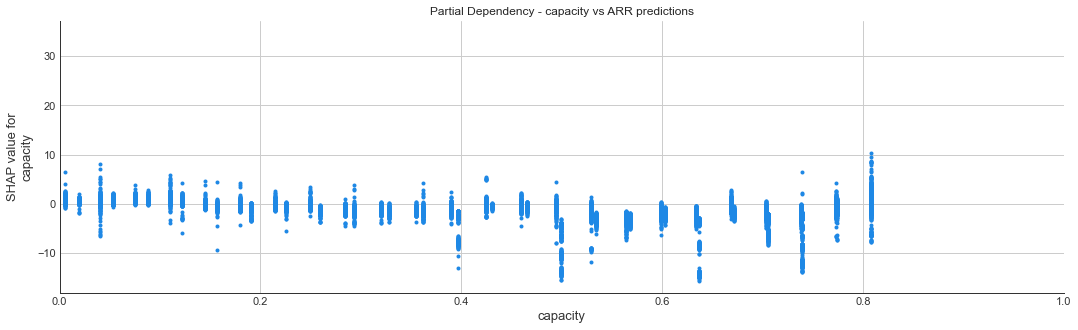

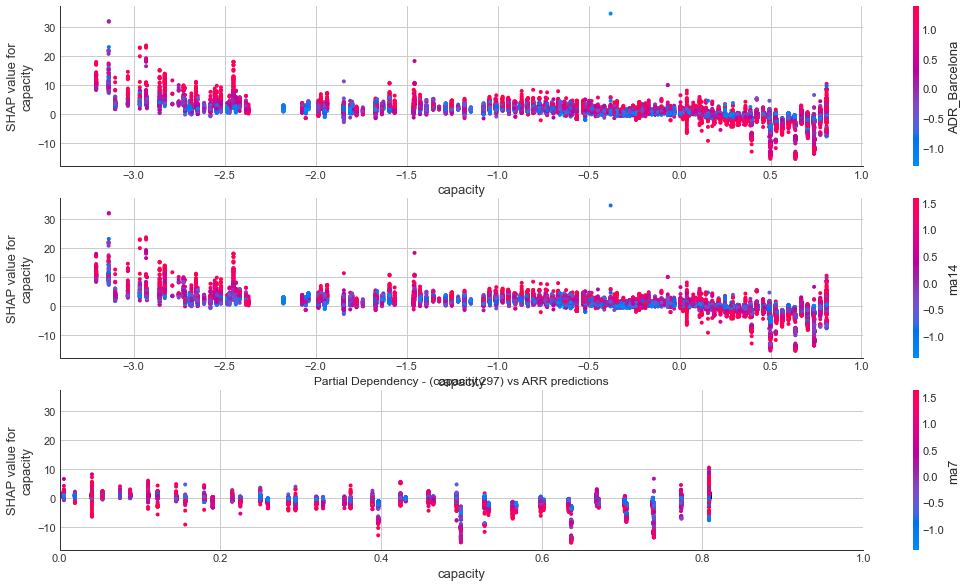

In [165]:
feature_id = 'capacity' if avail_path else 'bed_nights'

# Create object that can calculate shap values (SHapley Additive exPlanations)
explainer = shap.TreeExplainer(model)

# Calculate shap values. This is what we will plot.
shap_values = explainer.shap_values(X_train)

# Turn off interaction coloring:
fig, ax = plt.subplots(1, 1, figsize=(18,5))
shap.dependence_plot(feature_id, shap_values, X_train, interaction_index=None, ax=ax, show=False)
plt.xlim([0,1])
plt.title('Partial Dependency - %s vs %s predictions' % (feature_id, dependent_var))
plt.show()

# Make plots colored by each of the top three possible interacting features
inds = shap.approximate_interactions(feature_id, shap_values, X_train)
fig, ax = plt.subplots(3, 1, figsize=(18,10))
for i in range(3):
    shap.dependence_plot(feature_id, shap_values, X_train, interaction_index=inds[i], ax=ax[i], show=False)
plt.xlim([0,1])
plt.title('Partial Dependency - (%s,%s) vs %s predictions' % (feature_id, inds[i], dependent_var))
plt.show()    

<hr>

# Neural Networks

### Multi-layer Perceptron

A Multi-layer Perceptron (MLP) Regression System is a multilayer feedforward neural network training system that implements multi-layer perceptron regression algorithm to solve a Multi-layer Perceptron Regression Task.<br>

<div><img src="https://miro.medium.com/max/1400/1*-IPQlOd46dlsutIbUq1Zcw.png" width="500"/></div>

Model: mlp_regressor


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


CV Mean Accuracy:  -8.198847434568336e+34
CV STD Accuracy:  7.9312456652656365e+34 

Train Accuracy:  0.9211947963559355
Test Accuracy:  0


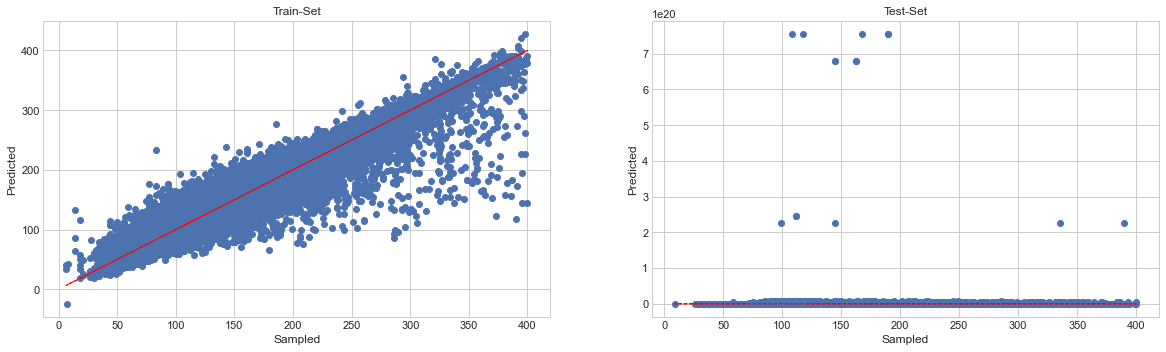

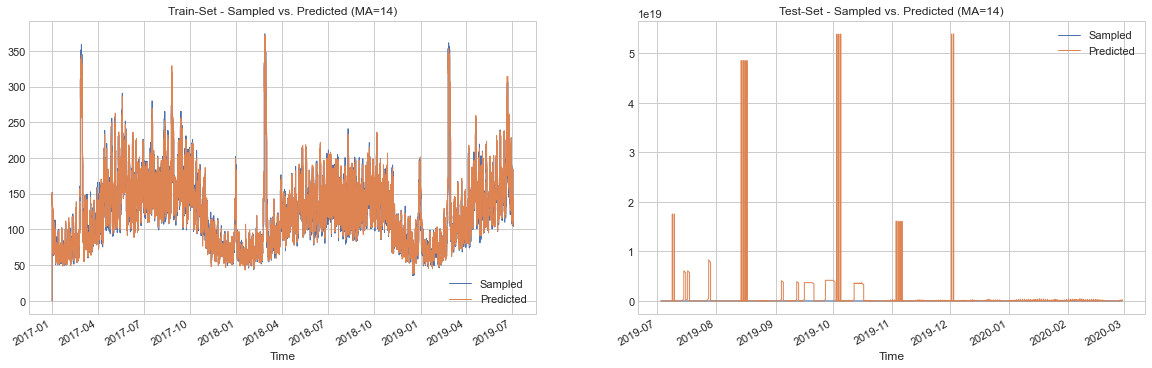

In [166]:
model_name = models[8]
print('Model: %s' % model_name)
model_file = save_path + "model_%s_h%d.pkl" % (model_name, hotel_sel)

if path.isfile(model_file) and not overwrite_saved_data:
    
    # Load an existing model
    model = joblib.load(model_file)

else:
    
    # Create object
    model = make_pipeline(StandardScaler(),
                          MLPRegressor(hidden_layer_sizes=(100, 100),
                                       tol=1e-2, 
                                       max_iter=500,
                                       random_state=0))

    # Train the model using the training sets
    model.fit(X_train, y_train)
    
    # Save the model
    joblib.dump(model, model_file)

    # Get cross validation scores
    get_cv_scores(model, X_train, y_train)

print_model_accuracy(model, X_train, y_train, X_test, y_test)
    
# Make predictions using the testing set
y_pred = model.predict(X_test)

# Plot
plot_model_results(model, X_train, X_test, y_train, y_test, y_pred)

<hr>

### LSTM RNN (Tensorflow)

Recurrent Neural Networks (RNN) have been proven to efficiently solve sequence problems. Particularly, Long Short Term Memory Network (LSTM), which is a variation of RNN, is currently being used in a variety of domains to solve sequence problems.<br>
<br>
<div><img src="https://i.stack.imgur.com/Mpzfy.jpg" width="500"/></div>

In [167]:
def lstm_calculate_loss(model, dataset, dataset_idx, X_true, plot_en=True):

    # Predict:
    Xpred = model.predict(dataset)
    Xpred = pd.DataFrame(Xpred, index=dataset_idx, columns=[dependent_var])

    # Ground Truth:
    Xtrue = X_true.copy()
    Xtrue = pd.DataFrame(Xtrue, index=dataset_idx, columns=[dependent_var])

    # Loss calculation:
    loss_mae = pd.DataFrame(index=dataset_idx)
    loss_mae = np.mean(np.abs(Xpred-Xtrue), axis=1)

    # R2 score
    r2 = r2_score(Xtrue[dependent_var], Xpred[dependent_var])
    
    # Plot:
    if plot_en:
        fig, axes = plt.subplots(2, 1, figsize=(30,15))
        sns.distplot(loss_mae, bins=20, kde=True, color='blue', ax=axes[0])
        axes[0].set_title('Loss Distribution', fontsize=20)
        axes[0].set_xlabel('Loss Distribution', fontsize=15)
        #axes[0].set_xlim([0.0,.5])
        axes[1].set_title('Sampled vs. Predicted', fontsize=20)
        axes[1].set_xlabel('Time', fontsize=15)
        Xtrue[dependent_var].plot(subplots=True, ax=axes[1], color='Blue', label='Sampeld')
        Xpred[dependent_var].plot(subplots=True, ax=axes[1], color='Green', label='Predicted')
        axes[1].legend()
        plt.show()
        
    return loss_mae, Xtrue, Xpred, r2

Model: lstm_rnn
Epoch 1/1000
154/154 - 2s - loss: 17266.1250 - val_loss: 26693.5859
Epoch 2/1000
154/154 - 1s - loss: 13079.7627 - val_loss: 23959.2383
Epoch 3/1000
154/154 - 1s - loss: 9720.6475 - val_loss: 21588.2754
Epoch 4/1000
154/154 - 1s - loss: 7551.7236 - val_loss: 19990.3750
Epoch 5/1000
154/154 - 1s - loss: 6113.1792 - val_loss: 18845.2051
Epoch 6/1000
154/154 - 1s - loss: 5113.9531 - val_loss: 17984.5996
Epoch 7/1000
154/154 - 1s - loss: 4375.4614 - val_loss: 17173.3770
Epoch 8/1000
154/154 - 1s - loss: 3831.6226 - val_loss: 16576.4785
Epoch 9/1000
154/154 - 1s - loss: 3419.2380 - val_loss: 16098.8887
Epoch 10/1000
154/154 - 1s - loss: 3093.9792 - val_loss: 15649.1895
Epoch 11/1000
154/154 - 1s - loss: 2823.1375 - val_loss: 15266.3086
Epoch 12/1000
154/154 - 1s - loss: 2611.1792 - val_loss: 14906.8994
Epoch 13/1000
154/154 - 1s - loss: 2428.1003 - val_loss: 14557.8857
Epoch 14/1000
154/154 - 1s - loss: 2261.6331 - val_loss: 14255.1396
Epoch 15/1000
154/154 - 1s - loss: 2127

Epoch 123/1000
154/154 - 1s - loss: 756.7422 - val_loss: 8672.9736
Epoch 124/1000
154/154 - 1s - loss: 755.8474 - val_loss: 8705.6357
Epoch 125/1000
154/154 - 1s - loss: 756.7245 - val_loss: 8685.6660
Epoch 126/1000
154/154 - 1s - loss: 758.0635 - val_loss: 8646.0420
Epoch 127/1000
154/154 - 1s - loss: 753.0453 - val_loss: 8576.5479
Epoch 128/1000
154/154 - 1s - loss: 753.6987 - val_loss: 8590.7959
Epoch 129/1000
154/154 - 1s - loss: 747.7664 - val_loss: 8625.3467
Epoch 130/1000
154/154 - 1s - loss: 746.9873 - val_loss: 8627.9717
Epoch 131/1000
154/154 - 1s - loss: 751.4342 - val_loss: 8669.4580
Epoch 132/1000
154/154 - 1s - loss: 755.8163 - val_loss: 8619.0605
Epoch 133/1000
154/154 - 1s - loss: 751.1748 - val_loss: 8603.6064
Epoch 134/1000
154/154 - 1s - loss: 751.0919 - val_loss: 8575.4648
Epoch 135/1000
154/154 - 1s - loss: 744.7078 - val_loss: 8571.4570
Epoch 136/1000
154/154 - 1s - loss: 749.5353 - val_loss: 8628.8213
Epoch 137/1000
154/154 - 1s - loss: 742.0268 - val_loss: 8621.

Epoch 246/1000
154/154 - 1s - loss: 682.5975 - val_loss: 6977.2148
Epoch 247/1000
154/154 - 1s - loss: 677.9924 - val_loss: 6976.8799
Epoch 248/1000
154/154 - 1s - loss: 687.3868 - val_loss: 6949.6489
Epoch 249/1000
154/154 - 1s - loss: 685.7961 - val_loss: 6949.4468
Epoch 250/1000
154/154 - 1s - loss: 685.2686 - val_loss: 6975.0371
Epoch 251/1000
154/154 - 1s - loss: 686.3451 - val_loss: 7003.1533
Epoch 252/1000
154/154 - 1s - loss: 682.9254 - val_loss: 6956.0615
Epoch 253/1000
154/154 - 1s - loss: 687.1298 - val_loss: 6955.9155
Epoch 254/1000
154/154 - 1s - loss: 678.6614 - val_loss: 6945.4331
Epoch 255/1000
154/154 - 1s - loss: 684.1638 - val_loss: 6927.1528
Epoch 256/1000
154/154 - 1s - loss: 687.7158 - val_loss: 6939.5669
Epoch 257/1000
154/154 - 1s - loss: 677.3007 - val_loss: 6899.2178
Epoch 258/1000
154/154 - 1s - loss: 672.3644 - val_loss: 6881.5317
Epoch 259/1000
154/154 - 1s - loss: 667.8411 - val_loss: 6891.7573
Epoch 260/1000
154/154 - 1s - loss: 681.8284 - val_loss: 6841.

Epoch 369/1000
154/154 - 1s - loss: 655.1265 - val_loss: 6086.5366
Epoch 370/1000
154/154 - 1s - loss: 647.0797 - val_loss: 6074.4492
Epoch 371/1000
154/154 - 1s - loss: 652.7167 - val_loss: 6083.1421
Epoch 372/1000
154/154 - 1s - loss: 650.4582 - val_loss: 6079.2231
Epoch 373/1000
154/154 - 1s - loss: 657.1045 - val_loss: 6026.3936
Epoch 374/1000
154/154 - 1s - loss: 650.0820 - val_loss: 5953.5972
Epoch 375/1000
154/154 - 1s - loss: 646.2358 - val_loss: 5907.6479
Epoch 376/1000
154/154 - 1s - loss: 648.6558 - val_loss: 5885.3408
Epoch 377/1000
154/154 - 1s - loss: 651.5131 - val_loss: 5868.0244
Epoch 378/1000
154/154 - 1s - loss: 649.8671 - val_loss: 5774.8276
Epoch 379/1000
154/154 - 1s - loss: 649.6841 - val_loss: 5804.5737
Epoch 380/1000
154/154 - 1s - loss: 643.9593 - val_loss: 5776.3081
Epoch 381/1000
154/154 - 1s - loss: 648.4649 - val_loss: 5761.9595
Epoch 382/1000
154/154 - 1s - loss: 642.9477 - val_loss: 5802.3398
Epoch 383/1000
154/154 - 1s - loss: 654.7675 - val_loss: 5823.

Epoch 492/1000
154/154 - 1s - loss: 632.8878 - val_loss: 4961.0850
Epoch 493/1000
154/154 - 1s - loss: 636.0939 - val_loss: 4991.6021
Epoch 494/1000
154/154 - 1s - loss: 632.3016 - val_loss: 4946.4585
Epoch 495/1000
154/154 - 1s - loss: 631.4120 - val_loss: 4970.6074
Epoch 496/1000
154/154 - 1s - loss: 631.4567 - val_loss: 4914.9282
Epoch 497/1000
154/154 - 1s - loss: 629.0196 - val_loss: 4898.3774
Epoch 498/1000
154/154 - 1s - loss: 634.5639 - val_loss: 4930.5850
Epoch 499/1000
154/154 - 1s - loss: 630.9643 - val_loss: 4891.0962
Epoch 500/1000
154/154 - 1s - loss: 629.0130 - val_loss: 4897.3022
Epoch 501/1000
154/154 - 1s - loss: 627.8492 - val_loss: 4922.0571
Epoch 502/1000
154/154 - 1s - loss: 625.1151 - val_loss: 4914.4507
Epoch 503/1000
154/154 - 1s - loss: 625.1233 - val_loss: 4881.6582
Epoch 504/1000
154/154 - 1s - loss: 631.5380 - val_loss: 4869.9932
Epoch 505/1000
154/154 - 1s - loss: 628.2134 - val_loss: 4874.8540
Epoch 506/1000
154/154 - 1s - loss: 635.3305 - val_loss: 4852.

Epoch 615/1000
154/154 - 1s - loss: 623.9893 - val_loss: 4307.2871
Epoch 616/1000
154/154 - 1s - loss: 618.5847 - val_loss: 4236.2886
Epoch 617/1000
154/154 - 1s - loss: 617.0432 - val_loss: 4247.8579
Epoch 618/1000
154/154 - 1s - loss: 631.6366 - val_loss: 4183.4961
Epoch 619/1000
154/154 - 1s - loss: 620.6646 - val_loss: 4177.5122
Epoch 620/1000
154/154 - 1s - loss: 613.1108 - val_loss: 4231.3857
Epoch 621/1000
154/154 - 1s - loss: 618.5436 - val_loss: 4177.3623
Epoch 622/1000
154/154 - 1s - loss: 616.5359 - val_loss: 4144.8262
Epoch 623/1000
154/154 - 1s - loss: 614.1811 - val_loss: 4137.8643
Epoch 624/1000
154/154 - 1s - loss: 623.8821 - val_loss: 4163.7290
Epoch 625/1000
154/154 - 1s - loss: 610.2962 - val_loss: 4152.3379
Epoch 626/1000
154/154 - 1s - loss: 620.3447 - val_loss: 4163.5884
Epoch 627/1000
154/154 - 1s - loss: 621.7060 - val_loss: 4111.9053
Epoch 628/1000
154/154 - 1s - loss: 613.9304 - val_loss: 4136.0620
Epoch 629/1000
154/154 - 1s - loss: 624.0315 - val_loss: 4158.

Epoch 738/1000
154/154 - 1s - loss: 604.2570 - val_loss: 3959.6638
Epoch 739/1000
154/154 - 1s - loss: 610.0493 - val_loss: 3985.6816
Epoch 740/1000
154/154 - 1s - loss: 605.6332 - val_loss: 3910.8875
Epoch 741/1000
154/154 - 1s - loss: 608.9216 - val_loss: 3904.2991
Epoch 742/1000
154/154 - 1s - loss: 619.8229 - val_loss: 3863.8152
Epoch 743/1000
154/154 - 1s - loss: 609.4749 - val_loss: 3887.5571
Epoch 744/1000
154/154 - 1s - loss: 605.7450 - val_loss: 3918.5051
Epoch 745/1000
154/154 - 1s - loss: 606.5331 - val_loss: 3947.4150
Epoch 746/1000
154/154 - 1s - loss: 604.2851 - val_loss: 4005.7214
Epoch 747/1000
154/154 - 1s - loss: 600.0176 - val_loss: 3993.9055
Epoch 748/1000
154/154 - 1s - loss: 606.0575 - val_loss: 4042.8521
Epoch 749/1000
154/154 - 1s - loss: 606.2293 - val_loss: 3980.5483
Epoch 750/1000
154/154 - 1s - loss: 609.0061 - val_loss: 3932.2100
Epoch 751/1000
154/154 - 1s - loss: 609.8969 - val_loss: 3910.5730
Epoch 752/1000
154/154 - 1s - loss: 603.4600 - val_loss: 3945.

Epoch 861/1000
154/154 - 1s - loss: 599.7361 - val_loss: 3713.6355
Epoch 862/1000
154/154 - 1s - loss: 602.8661 - val_loss: 3721.6917
Epoch 863/1000
154/154 - 1s - loss: 598.3759 - val_loss: 3698.3484
Epoch 864/1000
154/154 - 1s - loss: 599.4441 - val_loss: 3619.7637
Epoch 865/1000
154/154 - 2s - loss: 601.5686 - val_loss: 3658.7566
Epoch 866/1000
154/154 - 1s - loss: 603.1069 - val_loss: 3645.8335
Epoch 867/1000
154/154 - 2s - loss: 601.1624 - val_loss: 3701.3052
Epoch 868/1000
154/154 - 2s - loss: 606.7889 - val_loss: 3668.7952
Epoch 869/1000
154/154 - 2s - loss: 600.6503 - val_loss: 3697.3008
Epoch 870/1000
154/154 - 2s - loss: 600.5615 - val_loss: 3686.9622
Epoch 871/1000
154/154 - 2s - loss: 602.4236 - val_loss: 3704.4463
Epoch 872/1000
154/154 - 1s - loss: 600.0551 - val_loss: 3701.2146
Epoch 873/1000
154/154 - 1s - loss: 600.4014 - val_loss: 3675.5659
Epoch 874/1000
154/154 - 2s - loss: 602.7933 - val_loss: 3679.5974
Epoch 875/1000
154/154 - 1s - loss: 600.5038 - val_loss: 3692.

Epoch 984/1000
154/154 - 2s - loss: 595.6970 - val_loss: 3209.1428
Epoch 985/1000
154/154 - 2s - loss: 598.3941 - val_loss: 3196.7327
Epoch 986/1000
154/154 - 2s - loss: 594.9066 - val_loss: 3204.9731
Epoch 987/1000
154/154 - 2s - loss: 597.9474 - val_loss: 3188.7214
Epoch 988/1000
154/154 - 2s - loss: 591.7469 - val_loss: 3151.7883
Epoch 989/1000
154/154 - 2s - loss: 598.0509 - val_loss: 3153.7756
Epoch 990/1000
154/154 - 2s - loss: 599.3524 - val_loss: 3165.1313
Epoch 991/1000
154/154 - 2s - loss: 590.6387 - val_loss: 3151.1409
Epoch 992/1000
154/154 - 2s - loss: 591.5391 - val_loss: 3149.4119
Epoch 993/1000
154/154 - 1s - loss: 600.0277 - val_loss: 3121.5688
Epoch 994/1000
154/154 - 1s - loss: 600.8817 - val_loss: 3111.8682
Epoch 995/1000
154/154 - 1s - loss: 597.3685 - val_loss: 3120.4060
Epoch 996/1000
154/154 - 1s - loss: 594.4266 - val_loss: 3136.0308
Epoch 997/1000
154/154 - 1s - loss: 597.7342 - val_loss: 3117.4695
Epoch 998/1000
154/154 - 2s - loss: 592.4078 - val_loss: 3115.

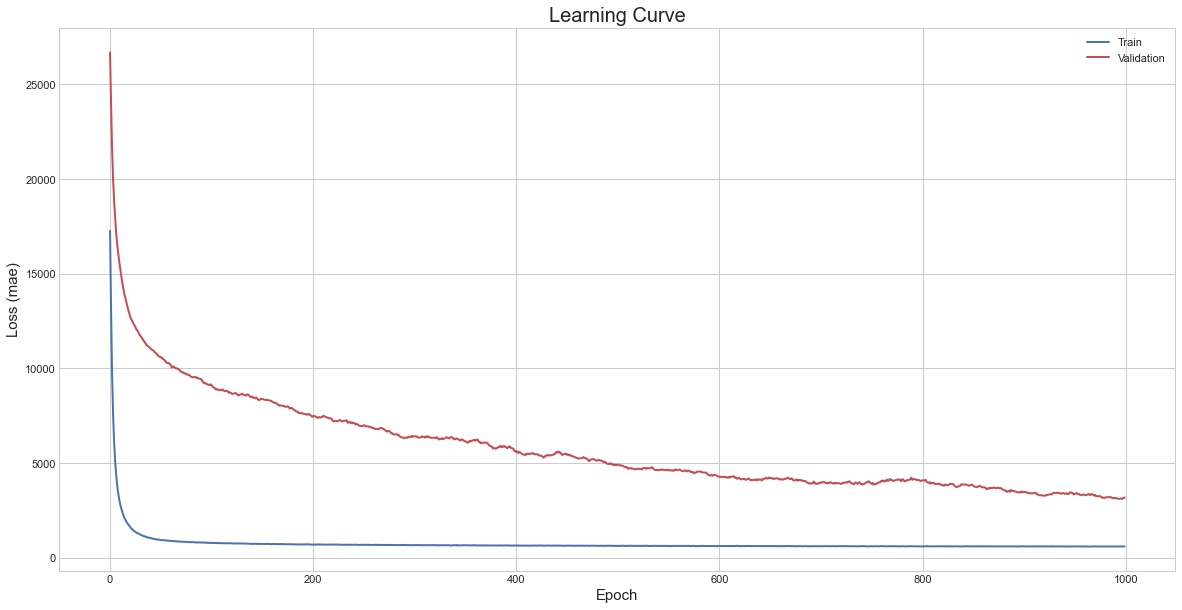

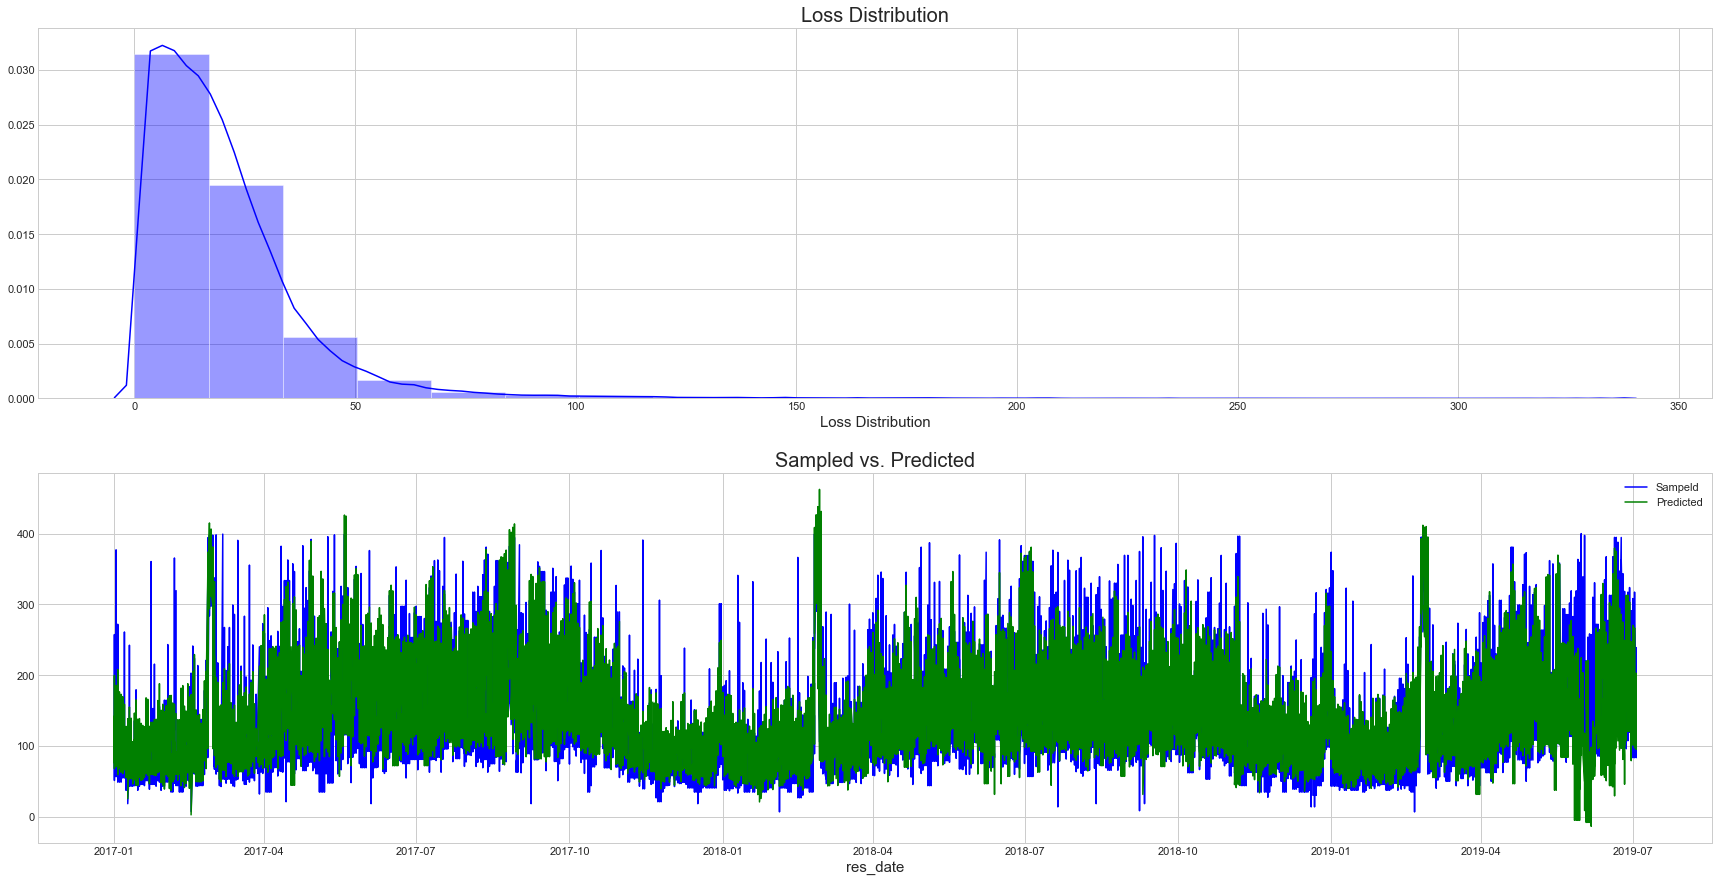

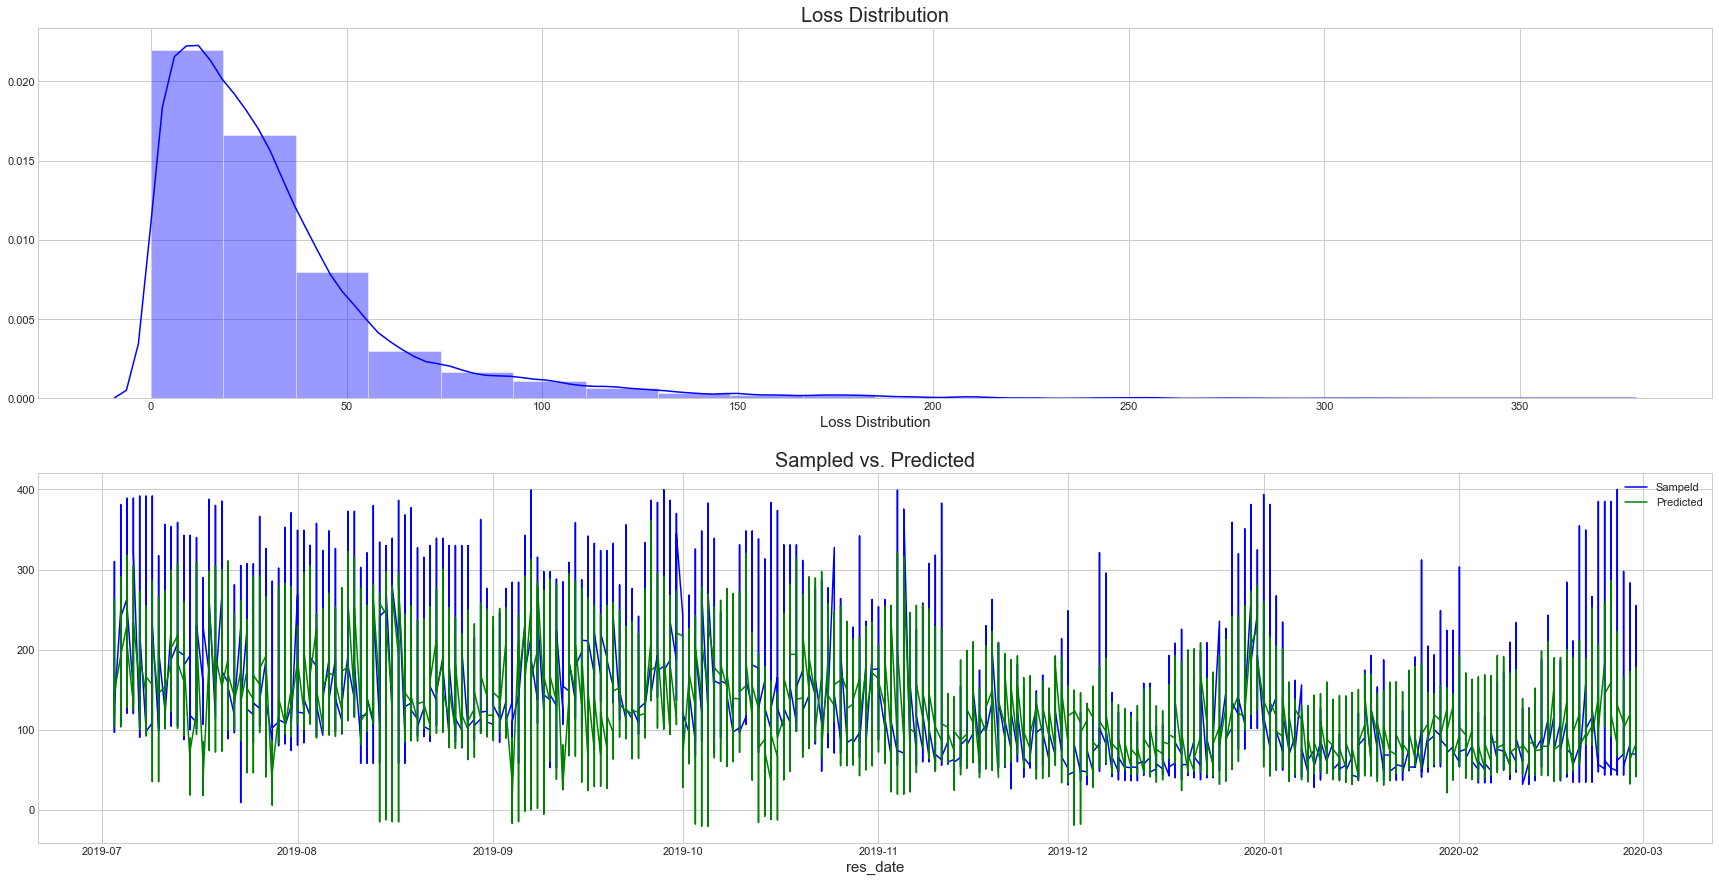

Train Accuracy: 0.76177 (loss MAE = 33.113)
Test Accuracy: 0.45407 (loss MAE = 6.705)


In [168]:
model_name = models[9]
print('Model: %s' % model_name)
model_file = save_path + "model_%s_h%d.h5" % (model_name, hotel_sel)

# Dataframe to Numpy array
X_train_np = X_train.to_numpy()
X_test_np = X_test.to_numpy()
y_train_np = y_train.to_numpy()
y_test_np = y_test.to_numpy()    

# Samples, TimeSteps, Features
X_train_shaped = X_train_np.reshape(X_train_np.shape[0], 1, X_train_np.shape[1])
X_test_shaped = X_test_np.reshape(X_test_np.shape[0], 1, X_test_np.shape[1])

# Samples, Features
y_train_shaped = y_train_np.reshape(y_train_np.shape[0], 1)
y_test_shaped = y_test_np.reshape(y_test_np.shape[0], 1)

if path.isfile(model_file) and not overwrite_saved_data:
    
    # Load an existing model
    model = load_model(model_file)
    history = joblib.load(model_file.replace('.h5','.pkl'))
    
else:
    
    # TensorFlow Initialization
    tf.compat.v1.set_random_seed(33)
    environ['PYTHONHASHSEED'] = str(33)
    np.random.seed(33)
    stacked_lstm = False
    n_nuerons = 128
    
    # Create the LSTM RNN model
    model = Sequential()
    if stacked_lstm:
        model.add(LSTM(n_nuerons, return_sequences=True, input_shape=(1, X_train.shape[1]), dropout=0.3))
        model.add(LSTM(n_nuerons/2, return_sequences=True, dropout=0.3))
        model.add(LSTM(n_nuerons/4, return_sequences=True, dropout=0.3))
        model.add(LSTM(n_nuerons/8, dropout=0.3))
    else:
        model.add(LSTM(n_nuerons, input_shape=(1, X_train.shape[1]), dropout=0.3))                      
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    
    # Fit the model to the data
    history = model.fit(X_train_shaped,
                        y_train_shaped,
                        epochs=1000, 
                        batch_size=512,
                        validation_split=0.05,
                        verbose=2).history
    
    # Save all model information, including weights, in h5 format
    model.save(model_file)
    print("Model saved (%s)" % model_file)

    # Save history to pickle
    joblib.dump(history, model_file.replace('.h5','.pkl'))

# Print Model summary
print(model.summary())

# Plot learning-curve
plot_learning_curve(history)

# Evaluate model:
(loss_mae_trn, X_true_trn, X_pred_trn, r2_trn) = lstm_calculate_loss(
    model, X_train_shaped, X_train.index, y_train_shaped)

(loss_mae_tst, X_true_tst, X_pred_tst, r2_tst) = lstm_calculate_loss(
    model, X_test_shaped, X_test.index, y_test_shaped)

# Save R2 results
if 'r2_train' not in history:
    history = joblib.load(model_file.replace('.h5','.pkl'))
    history['r2_train'] = r2_trn
    history['r2_test'] = r2_tst
    joblib.dump(history, model_file.replace('.h5','.pkl'))

# Calculate Accuracy
print('Train Accuracy: %.5f (loss MAE = %.3f)' % (r2_trn, loss_mae_trn.iloc[-1]))
print('Test Accuracy: %.5f (loss MAE = %.3f)' % (r2_tst, loss_mae_tst.iloc[-1]))

<hr>

### LSTM AutoEncoder (Tensorflow)

LSTM Autoencoders are composed by a simple LSTM encoder layer, followed by another simple LSTM decoder and by  TimeDistributed layer at the end.<br>
The idea here is to treat the dependant variable (y) as part of the features (X). We'll try to encode the whole set (Xy) and the decode it back.<br>
We will create a composite LSTM Autoencoder that has a single encoder and two decoders, one for reconstruction and one for prediction.<br>
<br>
<div><img src="https://miro.medium.com/max/1400/1*ZAorCoNenSYwDhTkFzqEGw.jpeg" width="500"/></div>

In [169]:
def autoencoder_calculate_loss(model, dataset, dataset_cols, dataset_idx, scaler_xy, plot_en=True):

    # Predict:
    Xpred = model.predict(dataset)
    Xpred = Xpred.reshape(Xpred.shape[0], Xpred.shape[1])
    Xpred = pd.DataFrame(Xpred, columns=dataset_cols)
    Xpred.index = dataset_idx

    # Ground Truth:
    Xtrue = dataset.reshape(dataset.shape[0], dataset.shape[1])
    Xtrue = pd.DataFrame(Xtrue, columns=dataset_cols)
    Xtrue.index = dataset_idx

    # Loss calculation:
    loss_mae = pd.DataFrame(index=dataset_idx)
    loss_mae = np.mean(np.abs(Xpred-Xtrue), axis=1)

    # UnScaling:
    Xy_dummy = dataset.copy()
    Xy_dummy = Xy_dummy.reshape(Xy_dummy.shape[0], Xy_dummy.shape[1])
    Xy_dummy = pd.DataFrame(Xy_dummy, columns=dataset_cols)
    Xy_dummy.index = dataset_idx
    Xy_dummy[dependent_var] = Xpred[dependent_var].values
    y_pred = scaler_xy.inverse_transform(Xy_dummy)[:, [-1]]
    Xy_dummy[dependent_var] = Xtrue[dependent_var].values
    y_true = scaler_xy.inverse_transform(Xy_dummy)[:, [-1]]
    
    # R2 score
    r2 = r2_score(Xtrue[dependent_var], Xpred[dependent_var])    
    
    # Plot:
    if plot_en:
        
        y_smp = pd.DataFrame(y_true, index=dataset_idx)
        y_prd = pd.DataFrame(y_pred, index=dataset_idx)

        y_smp_ma = y_smp.groupby(y_smp.index).mean().rolling(window=14).mean().fillna(0)
        y_prd_ma = y_prd.groupby(y_prd.index).mean().rolling(window=14).mean().fillna(0)

        y_ma = pd.concat([y_smp_ma, y_prd_ma], axis=1)
        y_ma.columns = ['Sampled', 'Predicted']
        
        fig, ax = plt.subplots(1, 1, figsize=(15,10))
        sns.distplot(loss_mae, bins=20, kde=True, color='blue', ax=ax)
        ax.set_title('Loss Distribution', fontsize=20)
        ax.set_xlabel('Loss Distribution', fontsize=15)
        #ax.set_xlim([0.0,.5])
        plt.show()

        fig, ax = plt.subplots(1, 1, figsize=(15,10))
        y_ma.plot(ax=ax, linewidth=1)
        ax.xaxis_date()
        ax.set_title('Sampled vs. Predicted (MA=14)')
        ax.set_xlabel('Time')
        ax.legend()
        fig.autofmt_xdate()        
        plt.show()
        
    return loss_mae, Xtrue, Xpred, r2

In [170]:
%%script false --no-raise-error

model_name = models[10]
print('Model: %s' % model_name)
model_file = save_path + "model_%s_h%d.h5" % (model_name, hotel_sel)

# Dataframe to Numpy array
X_train_np = Xy_train.to_numpy()
X_test_np = Xy_test.to_numpy()

# Reshape inputs for LSTM [samples, features, timesteps]
X_train_shaped = X_train_np.astype(np.float64).reshape(X_train_np.shape[0], X_train_np.shape[1], 1)
X_test_shaped = X_test_np.astype(np.float64).reshape(X_test_np.shape[0], X_test_np.shape[1], 1)

if path.isfile(model_file) and not overwrite_saved_data:
    
    # Load an existing model
    model = load_model(model_file)
    history = joblib.load(model_file.replace('.h5','.pkl'))
    
else:

    # TensorFlow Initialization
    tf.compat.v1.set_random_seed(33)
    environ['PYTHONHASHSEED'] = str(33)
    np.random.seed(33)

    sequence_length = 4

    session_conf = tf.compat.v1.ConfigProto(
        intra_op_parallelism_threads=1, 
        inter_op_parallelism_threads=1
    )
    sess = tf.compat.v1.Session(
        graph=tf.compat.v1.get_default_graph(), 
        config=session_conf
    )
    tf.compat.v1.keras.backend.set_session(sess)

    # Create the autoencoder model
    sequence_length = X_train_np.shape[1]
    inputs_ae = Input(shape=(sequence_length, 1))
    encoded_ae = LSTM(128, return_sequences=True, dropout=0.3)(inputs_ae, training=True)
    decoded_ae = LSTM(32, return_sequences=True, dropout=0.3)(encoded_ae, training=True)
    out_ae = TimeDistributed(Dense(1))(decoded_ae)

    model = Model(inputs_ae, out_ae)
    model.compile(optimizer='adam', loss='mse', metrics=['mse'])

    # Fit the model to the data
    history = model.fit(X_train_shaped,
                        X_train_shaped,
                        epochs=100,
                        batch_size=128,
                        validation_split=0.2,
                        verbose=2,
                        shuffle=True).history

    # Save all model information, including weights, in h5 format
    model.save(model_file)
    print("Model saved (%s)" % model_file)

    # Save history to pickle
    joblib.dump(history, model_file.replace('.h5','.pkl'))

# Print Model summary
print(model.summary())
    
# Plot learning-curve
plot_learning_curve(history)

# Evaluate model:
(loss_mae_trn, X_true_trn, X_pred_trn, r2_trn) = autoencoder_calculate_loss(
    model, X_train_shaped, Xy_train.columns, Xy_train.index, scaler_xy_train)

(loss_mae_tst, X_true_tst, X_pred_tst, r2_tst) = autoencoder_calculate_loss(
    model, X_test_shaped, Xy_test.columns, Xy_test.index, scaler_xy_test)

# Save R2 results
if 'r2_train' not in history:
    history = joblib.load(model_file.replace('.h5','.pkl'))
    history['r2_train'] = r2_trn
    history['r2_test'] = r2_tst
    joblib.dump(history, model_file.replace('.h5','.pkl'))

# Calculate Accuracy
print('Train Accuracy: (r2, loss MAE): %.5f, %.3f' % (r2_trn, loss_mae_trn.iloc[-1]))
print('Test Accuracy: (r2, loss MAE): %.5f, %.3f' % (r2_tst, loss_mae_tst.iloc[-1]))

### Forecasting

WIP

<hr>

# Statistical Forecasting

### SARIMAX

An ARIMA model is one where a time series get differenced d times to make it stationary, and then combine the AR and the MA terms.   
So the equation becomes:
<br>
<br>
$
\begin{align}
Y_t = \alpha + \beta_1Y_{t-1} + \beta_2Y_{t-2} + ... + \beta_pY_{t-p} + \epsilon_t + \phi_1\epsilon_{t-1} + \phi_2\epsilon_{t-2} + ... + \phi_q\epsilon_{t-q}
\end{align}
$
<br>
<br>
Linear regression models work best when the predictors are not correlated and are independent of each other.   
Hence, the first step to build an ARIMA model is to __make the time series stationary__.   
<br>
The __SARIMAX__ extension of ARIMA that explicitly models the seasonal element in univariate data.
<br>
<br>
There are three __trend elements__ (same as in the ARIMA model):
- p: Trend autoregression order
- d: Trend difference order
- q: Trend moving average order

There are four __seasonal elements__ (not part of ARIMA):
- P: Seasonal autoregressive order.
- D: Seasonal difference order.
- Q: Seasonal moving average order.
- m: The number of time steps for a single seasonal period.

In [171]:
def test_adf(series):
    '''
    Augmented Dickey-Fuller is the most popular statistical method to find if the series is stationary or not.
    It is also called as Unit Root Test.
    If value of p <0.05, then the data is stationary else the data is not stationary.
    '''
    
    dfout = {}
    dftest = sm.tsa.adfuller(series.dropna(), 
                             autolag='AIC', 
                             regression='ct')
    
    for key,val in dftest[4].items():
        dfout[f'critical value ({key})'] = val
    
    adf_p_value = dftest[1]
    
    is_stationary = adf_p_value <= 0.05
    
    if is_stationary:
        print("Strong evidence against Null Hypothesis")
        print("Reject Null Hypothesis - Data is Stationary")
        print("Data is Stationary (p=%.5f)" % adf_p_value)
    else:
        print("Strong evidence for  Null Hypothesis")
        print("Accept Null Hypothesis - Data is not Stationary")
        print("Data is NOT Stationary (p=%.2f) for " % adf_p_value)
    
    return is_stationary

Strong evidence against Null Hypothesis
Reject Null Hypothesis - Data is Stationary
Data is Stationary (p=0.00000)
Model: sarima
(p,d,q) = (2, 0, 1)
(P,D,Q,s) = (0, 0, 0, 0)
AIC = -155509.46


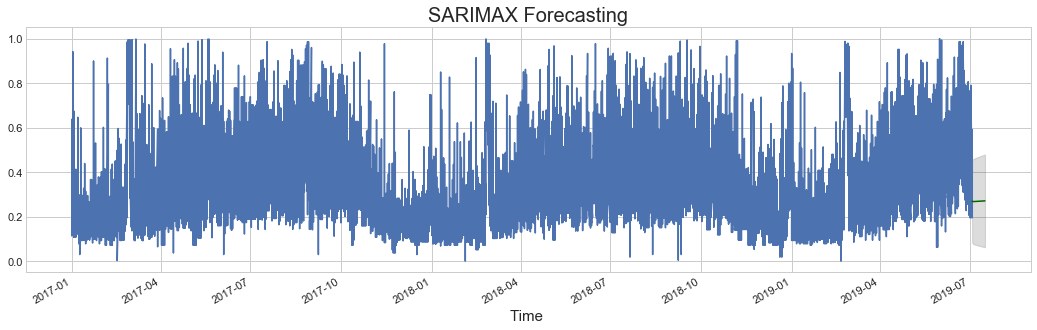

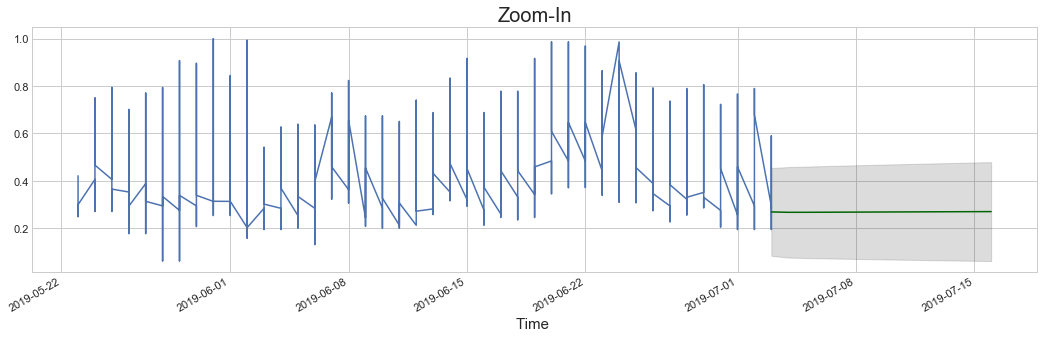

In [172]:
n_periods = 14  # amount of future time-samples to predict
n_zoom_in = 4000  # plotting zoom-in (last 'n_zoom_in' time-samples) 

# Normalization
sc_in = MinMaxScaler(feature_range=(0, 1))
out = pd.DataFrame(sc_in.fit_transform(pd.DataFrame(y_train)))
out.rename(columns={0:dependent_var}, inplace=True)

# Stationarity check
is_stationary = test_adf(out[dependent_var])
if not is_stationary:
    test_adf(out.diff())
    
model_name = models[11]
print('Model: %s' % model_name)
model_file = save_path + "model_%s_h%d.pkl" % (model_name, hotel_sel)

if path.isfile(model_file) and not overwrite_saved_data:
    
    # Load an existing model
    model = joblib.load(model_file)
    
else:

    # Create the arima model + Auto Fit:
    model = auto_arima(out,
                       start_p=1,        # min_p (AR term)
                       start_q=1,        # min_q (MA term)
                       test='adf',       # use ADF test to find optimal 'd'
                       max_p=3,          # max p (AR term)
                       max_q=3,          # max q (MA term)
                       m=1,              # frequency of series
                       d=None,           # let model determine 'd'
                       seasonal=True,    # True for SARIMAX, False for No Seasonality
                       start_P=0,        # min_P (AR term of the seasonal model)
                       D=None,           # let model determine 'D'
                       trace=False,
                       error_action='ignore',  
                       suppress_warnings=True, 
                       stepwise=True)

    # Save the model
    joblib.dump(model, model_file)

print('(p,d,q) = %s' % str(model.get_params()['order']))
print('(P,D,Q,s) = %s' % str(model.get_params()['seasonal_order']))        
print('AIC = %.2f' % model.aic())

out.index = y_train.index

# Forecast
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)

# Make series for plotting purpose
fc_series = pd.Series(fc, index=pd.date_range(start=out.index[-1], periods=n_periods, freq='D'))

lower_series = pd.Series(confint[:, 0], index=fc_series.index)
upper_series = pd.Series(confint[:, 1], index=fc_series.index)

# Plot
fig, ax = plt.subplots(1, 1, figsize=(18,5))
ax.set_title('SARIMAX Forecasting', fontsize=20)
ax.set_xlabel('Time ', fontsize=15)
ax.plot(out)
ax.plot(fc_series, color='darkgreen')
ax.xaxis_date()
ax.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
fig.autofmt_xdate()
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(18,5))
ax.set_title('Zoom-In', fontsize=20)
ax.set_xlabel('Time ', fontsize=15)
ax.plot(out[-n_zoom_in:])
ax.plot(fc_series, color='darkgreen')
ax.xaxis_date()
ax.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
fig.autofmt_xdate()
plt.show()

### FBProphet

[Facebook Prophet](https://facebook.github.io/prophet/) is an additive regression model with four main components:
- A piecewise linear or logistic growth curve trend. Prophet automatically detects changes in trends by selecting changepoints from the data.
- A yearly seasonal component modeled using Fourier series.
- A weekly seasonal component using dummy variables.
- A user-provided list of important holidays.

Model: fbprophet


The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.


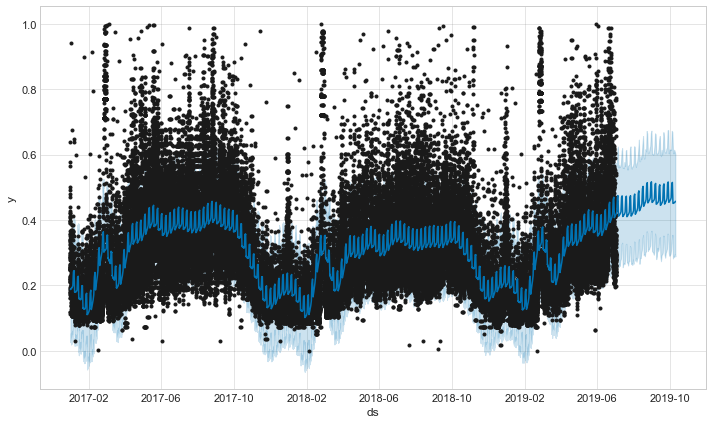

In [173]:
# Change the column names according to Prophet's guidelines:
out_df = out.copy().reset_index()
out_df.columns = ['ds', 'y']
out_df.T

# Split into a train/test set:
prediction_size = 100
train_df = out_df[:-prediction_size]

# Build an Prophet model:
model_name = "fbprophet"
print('Model: %s' % model_name)
model_file = save_path + "model_%s_h%d.pkl" % (model_name, hotel_sel)

if path.isfile(model_file) and overwrite_saved_data:
    
    # Load an existing model
    model = joblib.load(model_file)

else:

    model = Prophet()
    model.fit(train_df)
    
    # Save the model
    joblib.dump(model, model_file)
        
# Forecast:
future_df = model.make_future_dataframe(periods=prediction_size)
forecast_df = model.predict(future_df)
forecast_df.head()

# Plot forecast
model.plot(forecast_df)
plt.show()

# Plot forecast components:
#model.plot_components(forecast_df)
#plt.show()

<hr>

# Summary

In [174]:
summary = { 'train_accuracy': {}, 
            'test_accuracy': {} } 

for model_name in models:
    
    if model_name == 'sarima' or model_name == 'fbprophet' or model_name == 'lstm_autoencoder':
        continue
    
    model_file = save_path + "model_%s_h%d.pkl" % (model_name, hotel_sel)

    if path.isfile(model_file):
        
        model = joblib.load(model_file)
        
        if type(model) is dict:
            summary['train_accuracy'][model_name] = model['r2_train']
            summary['test_accuracy'][model_name] = model['r2_test']
        else:
            summary['train_accuracy'][model_name] = model.score(X_train, y_train)
            summary['test_accuracy'][model_name] = model.score(X_test, y_test)
    
    else:
        print("Skipping: %s" % model_file)
          
summary_df = pd.DataFrame(summary).astype(float).round(4)
summary_df[abs(summary_df)>1] = 0
display(summary_df)

train_accuracy  test_accuracy
linear_regressor                0.7810         0.0000
ridge_regressor                 0.7811         0.7304
lasso_regressor                 0.7795         0.7347
elasticnet_regressor            0.7397         0.6891
supportvect_regressor           0.7764         0.0000
decisiontree_regressor          1.0000         0.5325
randomforest_regressor          0.5855         0.5535
xgboost_regressor               0.8253         0.7549
mlp_regressor                   0.9212         0.0000
lstm_rnn                        0.7618         0.4541

<hr>

In [175]:
print('Completed')

Completed
